In [1]:
## all the necessary imports for the project

import json
import pickle
from gcmap import GCMapper, Gradient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.patches as mpatches
from fuzzywuzzy import process
from tqdm import tqdm
from functools import cache
import networkx as nx
import netwulf
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import ast
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from collections import defaultdict
import random
import igraph as ig
from adjustText import adjust_text
import leidenalg
import re
import nltk

c:\Users\Rasmu\anaconda3\envs\DM\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Motivation
We have chosen to work with a dataset of airports and flight connections between airports. Also, we will be looking at written reviews aswell as numerical, binary reviews ('recommended' or 'not recommended'). We want to answer the following research question:

***Where are the best airports located in the world? Are these airports connected to other airports of high quality? And, when adjusted for BNP per capita, where are the best airports compared to regional development?***

There are multiple ways of determining what a good airport is. We'll be looking at "average recommendation" (what percentage of users recommend the airport), "sentiment score" (how does people decribe the airports in textual reviews), and how well the airport is connected to other airports. 

To do this, we have chosen to work with the following datasets:
* [airports.dat](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat): The ID, city, country, and much more (13 attributes) of 7698 airports all over the globe. **Source**: January 2017, DAFIF (Digital Aeronautical Flight Information File) and OurAirports
* [routes.dat](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat): The source and destination, and more (9 attributes) of 67663 flights connecting between airports. **Source:** June 2014, Airline Route Mapper.
* [Airport reviews](https://github.com/quankiquanki/skytrax-reviews-dataset): 17721 text reviews of airports all over the world. Most text reviews also have a numerical rating. **Source**: github-user quankiquanki, obtained from Skytrax between 2007 and 2015.

We also collected information about BNP per capita and continents of the different countries/airports for two reasons: to standardize the airport ratings with regards to regional development (i.e. is there some airports that performs much better than expected based on BNP?) and to classify the airports into regions/continents for a high level grouping of airports.

* [BNP per capita](https://ourworldindata.org/grapher/gdp-per-capita-worldbank?time=2015): The BNP per capita of most countries in the world. Multiple years are available, we choose 2015 to overlap with the reviews. **Source**: World Bank (2023).
* [Continents](https://ourworldindata.org/world-region-map-definitions): The contient/region of every country. There are multiple ways of classifying regions of countries, we went with the more "traditional" way. **Source**: Our World In Data. 

### Our goal
Our goal is to give people an understanding of what level of quality one can expect from airports in differents parts of the world, both in terms of user satisfaction but also in terms of connectivity to other airports. 

# Basic stats
### Cleaning and preprocessing
First, we'll look at the "airports" dataset. This dataset contains the following attributes:
* id (name of airport)
* city
* country
* IATA (unique 3-letter code)
* ICAO (unique 4-letter code)
* latitude
* longitude
* altitude
* timezone 
* DST (daylight savings time)
* Tz database time zone (timezone in "tz" format)
* type (always airport)
* source

We are only interested in a subset of these, in particular *id, city, country, IATA, latitude* and *longitude*.
Therefore, we start of by removing NaN values where it matters (i.e. in the columns mentioned above).

In [48]:
cols = ["id", "city", "country", "IATA", "ICAO", "latitude", "longitude", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
cols_to_remove = ["ICAO", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
airports = pd.read_csv('data/airports.csv', index_col=0, names=cols, header=None)
airports = airports.drop(cols_to_remove, axis=1)
print("Length of airports before sorting: ", len(airports))

subset = ["IATA", "latitude", "longitude", "country", "city"]
airports = airports.dropna(subset=subset)
for col in subset:
    airports = airports[airports[col] != "\\N"]
    
print("Length of airports after sorting: ", len(airports))

Length of airports before sorting:  7698
Length of airports after sorting:  6033


Next, we make a dictionary mapping from country to continent, such that we can add continent to the above dataframe.

In [49]:
continents = pd.read_csv('data/continents.csv')
## make a dictionary of country to continent
country_to_continent = {}
for index, row in continents.iterrows():
    country = row['Entity']
    country_to_continent[row['Entity']] = row['Continent']
    
## show the first 5 entries of the dictionary
print("Example of country to continent dictionary:")
dict(list(country_to_continent.items())[0:5])

Example of country to continent dictionary:


{'Abkhazia': 'Asia',
 'Afghanistan': 'Asia',
 'Akrotiri and Dhekelia': 'Asia',
 'Aland Islands': 'Europe',
 'Albania': 'Europe'}

Similarily, we make a dictionary that maps from country to BNP, such that this can be added to the dataframe aswell. 
We only consider BNP from 2015, since this also around the time that the reviews are  gathered. 

In [50]:
BNP_per_capita = pd.read_csv('data/gdp-per-capita-worldbank.csv')
BNP_per_capita_2015 = BNP_per_capita[BNP_per_capita["Year"] == 2015]
## make a dictionary of country to BNP per capita
country_to_BNP_per_capita = {}
for index, row in BNP_per_capita_2015.iterrows():
    country = row['Entity']
    country_to_BNP_per_capita[country] = row['GDP per capita, PPP (constant 2017 international $)']
## see first 5 entries of the dictionary
print("Example of country to BNP per capita dictionary:")
dict(list(country_to_BNP_per_capita.items())[0:5])

Example of country to BNP per capita dictionary:


{'Afghanistan': 2108.714,
 'Albania': 11880.598,
 'Algeria': 11751.634,
 'Angola': 7967.104,
 'Antigua and Barbuda': 19345.018}

The data of continents/BNP comes from Our World In Data (OWID), and it doesn't match with the country names from the airport dataset. Therefore, we manually have to fix these names. 

In [51]:
countries_from_airports = airports['country'].unique()
countries_from_continents = continents['Entity'].unique()
countries_from_BNP = BNP_per_capita_2015['Entity'].unique()
## make a set of unique countries from continents and BNP
unique_countries = set(countries_from_continents).union(set(countries_from_BNP))
unique_countries = list(unique_countries)

## find the countries that are in airports but not in continents
print("These names should be fixed:")
print("-" * 20)
for country in countries_from_airports:
    if country not in unique_countries:
        print(country)
    
    
## this function is written AFTER examining the mismash of country names in the airports dataset
## and the continents dataset
## based on the print statement above ^
## we then manually looked at the mismatches and fixed them
def fix_country_name(name : str) -> str:
    """
    Function for matching up the country names in the airports dataset with the country names in the continents dataset.
    """
    
    if name[:5] == "Congo":
        return "Congo"
    
    if name == "Czech Republic":
        return "Czechia"
    
    if name == "Macedonia":
        return "North Macedonia"
    
    if name == "Swaziland":
        return "Eswatini"
    
    if name == "Micronesia":
        return "Micronesia (country)"
    
    if name == "Burma":
        return "Myanmar"
    
    if name in ["Midway Islands", "US Virgin Islands", "Virgin Islands", "Johnston Atoll", "Wake Island"]:
        return "United States"
    
    if name == "Macau":
        return "China"
    
    if name == "Cocos (Keeling) Islands":
        return "Australia"
    
    if name == "Russian Federation":
        return "Russia"
    
    return name

These names should be fixed:
--------------------
Congo (Brazzaville)
Congo (Kinshasa)
Swaziland
Czech Republic
Macedonia
Midway Islands
Micronesia
Virgin Islands
Macau
Burma
Johnston Atoll
Cocos (Keeling) Islands
Wake Island


We use the fixed country names to go from one dataset to the other. This way, we can confidently attribute the correct continent and BNP to each airport. 

In [52]:
## make a new column in the airports dataset with the continent
airports['continent'] = airports['country'].apply(fix_country_name).map(country_to_continent)
## same for the BNP per capita
airports['BNP per capita'] = airports['country'].apply(fix_country_name).map(country_to_BNP_per_capita)
## if the BNP is a nan, fill it with the mean
airports['BNP per capita'] = airports['BNP per capita'].fillna(airports['BNP per capita'].mean())

### Processing reviews
Now, we are going to look at the dataset of reviews. The reviews contains both text and numerical reviews. However, once again there are discrepancies between the names of the different datasets. This time, the names of each airport differs slightly. Therefore, we want to map each airport name from the "reviews" to the corresponding airport in the "airports" dataset. 
To do this, we will use the Levenshtein distance, which has been implemented in the python package `fuzzywuzzy`. 

**Optimization:** Unfortunately, the Levenshtein distance takes some time to run, and we have quite a lot of reviews. But since the same airports have multiple reviews, we don't need to calculate the corresponding name for each review but only for each airport. Therefore, we use the `functools.cache` wrapper which can remember function evaluations. 
This way, we have optimized our code from ~ 3 hours to ~ 5 minutes. 

The Levenshtein distance is defined as:
$$
lev(a[1..m], b[1..n]) = 
\begin{cases} 
m & \text{if } n = 0 \\
n & \text{if } m = 0 \\
lev(a[1..m-1], b[1..n-1]) & \text{if } a[m] = b[n] \\
1 + \min\begin{cases}
lev(a[1..m-1], b[1..n]) \\
lev(a[1..m], b[1..n-1]) \\
lev(a[1..m-1], b[1..n-1])
\end{cases} & \text{if } a[m] \neq b[n]
\end{cases}
$$
and it measures the number of deletions, substitutions, and insertions neccesary to go from string $a$ to string $b$. 

In [53]:
tqdm.pandas()

def format_name(name):
    name = name.replace("-", " ")
    ## make first letter in each word uppercase
    name = " ".join([word.capitalize() for word in name.split()])
    return name

@cache
def match_name(name, candidates):
    name = format_name(name)
    if name in candidates:
        return name
    
    ## get the best match
    match, score = process.extractOne(name, candidates)
    if score > 95:
        return match
    
    return None

In [54]:
airportreviews = pd.read_csv("data/airportreviews.csv")
cols_to_keep = ["airport_name", "recommended", "content"]
airportreviews = airportreviews[cols_to_keep]
airportreviews = airportreviews.dropna(subset=cols_to_keep)

candidates = airports['id'].unique()
candidates = tuple(candidates)
airportreviews["matched_name"] = airportreviews["airport_name"].progress_apply(lambda x: match_name(x, candidates))
airportreviews = airportreviews.dropna(subset=["matched_name"])

100%|██████████| 17721/17721 [05:51<00:00, 50.37it/s] 


Next up, we process the text reviews and numerical ratings of each airport. 
Text reviews are processed as a list of strings. 
Numerical ratings comes as 1's or 0's, i.e. "recommend" and "don't recommend". We have found the average of these numerical ratings, which amount to the fraction of positive reviews.
These are added to the "airports" dataset as a new column. 

**Optimization:** All this can be done extremely effective using the `groupby`, `apply` and `merge` functions in pandas. 

In [55]:
## for each airport in airports dataframe, insert the average recommendation score from airportsreviews
airportreviews["recommended"] = airportreviews["recommended"].astype(int)
average_recommendation = airportreviews.groupby("matched_name")["recommended"].mean().reset_index()
reviews_as_list = airportreviews.groupby("matched_name")["content"].apply(list).reset_index()
number_of_reviews = airportreviews.groupby("matched_name")["content"].count().reset_index()

average_recommendation.columns = ["id", "average_recommendation"]
reviews_as_list.columns = ["id", "content"]
number_of_reviews.columns = ["id", "number_of_reviews"]

airports = pd.merge(airports, number_of_reviews, how="left")
airports = pd.merge(airports, reviews_as_list, how="left")
airports = pd.merge(airports, average_recommendation, how="left")

## make a new column in airports which is recommended / BNP per capita 
## only if both are not nan
airports["recommended_BNP_ratio"] = np.nan
mask = (~airports["average_recommendation"].isna()) & (~airports["BNP per capita"].isna())
normalized_BNP = airports.loc[mask, "BNP per capita"] / airports.loc[mask, "BNP per capita"].max()
airports.loc[mask, "recommended_BNP_ratio"] = airports.loc[mask, "average_recommendation"] / normalized_BNP

In [56]:
## save to csv
## change to True if you want to save the airports dataframe to a csv file
## no need to run this cell if you don't want to save the dataframe
airports.to_csv("data/airports_cleaned.csv", index=False)

Unfortunately, a lot of aiport dont have any reviews. Our dataset contains a total of 6033 airports, but only 302 have reviews. 

In [57]:
print("Number of unique airport names in dataset:", len(airports))
airports_with_reviews = airports[airports["average_recommendation"].notnull()]
print("Number of unique airport names in reviews (i.e. number of airports with reviews):", len(airports_with_reviews))

Number of unique airport names in dataset: 6033
Number of unique airport names in reviews (i.e. number of airports with reviews): 197


### The final airport dataset
We now have the final dataset for the airports.

In [58]:
print("Size of dataframe in megabytes:", airports.memory_usage(deep=True).sum() / (1024 ** 2), "\n")
print("Rows and columns in dataframe:", airports.shape, "\n")
print("The variables in the dataframe are:")
print(airports.columns.tolist(), "\n")
print("The first 5 rows of the dataframe are:")
airports.head()

Size of dataframe in megabytes: 2.2296934127807617 

Rows and columns in dataframe: (6033, 12) 

The variables in the dataframe are:
['id', 'city', 'country', 'IATA', 'latitude', 'longitude', 'continent', 'BNP per capita', 'number_of_reviews', 'content', 'average_recommendation', 'recommended_BNP_ratio'] 

The first 5 rows of the dataframe are:


id          city  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            country IATA  latitude   longitude continent  BNP per capita  \
0  Papua New Guinea  GKA -6.081690  145.391998   Oceania       3813.1143   
1  Papua New Guinea  MAG -5.207080  145.789001   Oceania       3813.1143   
2  Papua New Guinea  HGU -5.826790  144.296005   Oceania       3813.1143   
3  Papua New Guinea  LAE -6.569803  146.725977   Oceania       3813.1143   
4  Papua New Guinea  POM -9.443380  147.220001   Oceania       3813.1143   

   number_of_reviews content  average_recommendation  recommended_BNP_ratio  
0                NaN     NaN                     NaN                    NaN  
1                NaN     NaN                     NaN                    NaN  
2                NaN     NaN                     NaN                    NaN  
3                NaN     NaN                     NaN                    NaN  
4                NaN     NaN                     NaN                    NaN

### Making the graph
To make the graph, we'll use Networkx. We'll format the graph as a dictionary to start of, which can then be passed to Networkx to create an actual graph. First, we'll make a dictionary for all nodes with their attributes (cityname, country, and so on). Each node will have a name according to their IATA (International Air Transport Association) code, which is a unique 3 digit identifier for each airport. 

In [59]:
## make a dictionary of IATA codes
## IATA code is a three-letter code designating many airports around the world
## for each airport, safe relevant information in a dictionary
IATA = {}
n = 0
for index, row in tqdm(airports.iterrows(), total=len(airports)):
    
    IATA[row['IATA']] = {
        'city': row['city'],                                                ## city
        'country': row['country'],                                          ## country
        'latitude': row['latitude'],                                        ## latitude
        'longitude': row['longitude'],                                      ## longitude
        'name': row['id'],                                                  ## name        
        'continent': row['continent'],                                      ## continent
        'group': row['continent'],                                          ## group      
        'BNP_per_capita': row['BNP per capita'],                            ## BNP per capita
        'average_recommendation': row['average_recommendation'],            ## average recommendation
        'average_recommendation_per_BNP': row['recommended_BNP_ratio'],     ## average recommendation per BNP
        'number_of_reviews': row['number_of_reviews'],                      ## number of reviews
    }
    
## save the dictionary to a file
with open('data/IATA.json', 'w') as f:
    json.dump(IATA, f)

100%|██████████| 6033/6033 [00:00<00:00, 7339.13it/s]


Now, lets look at the "flight" dataset, i.e. the dataset over flight connections. Once again, we'll filter this dataset by excluding NaN values and by only considering direct flight.The flight dataset has the following attributes:
* Airline (2 letter identifier code)
* Airline id (unique OpenFlights identifier code)
* Source airport (IATA code)
* Source airport id (unique OpenFlights identifier code)
* Destination airport (IATA code)
* Destination airport id (unique OpenFlights identifier code)
* Codeshare ("Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise)
* Stops (number of stops)
* Equipment (3 letter code for plane type)

We are ONLY interested in the source and destination airport, and since our other dataset consists of the IATA codes, we keep the "Source airport" and "Destination airport" columns.

In [60]:
cols = ["airline", "airline id", "source airport", "source airport id", "destination airport", "destination airport id", "codeshare", "stops", "equipment"]
flights = pd.read_csv('data/flights.csv', names=cols, header=None)
print("Number of connections before filtering:", len(flights))
flights = flights.dropna(subset=['source airport', 'destination airport'])
flights = flights[flights['stops'] == 0]  ## only direct flights
print("Number of connections after filtering:", len(flights))
flights.head()

Number of connections before filtering: 67663
Number of connections after filtering: 67652


airline airline id source airport source airport id destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  destination airport id codeshare  stops equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2

### Making the graph
Now, we can make the graph. We can do this using the module `networkx`. We'll model the graph as a directed graph, since the flights are flying from $a$ to $b$ and not neccesarily the other way. Though, we think that it would also be fair to model the graph as an undirected graph, since an airplane flying from $a$ to $b$ most likely also has to fly back from $b$ to $a$ at sometime. First, we'll add all nodes to the graph, and we will then add connections. 
<br>
The graph have been visualized using `netwulf`. 
NOTICE: when using `netwulf` we DO NOT consider the spatial position of each node. This will come later. 
<br>
We also remove nodes with no connections. Reason: we interpret nodes with no edges (i.e. airports with no flights) as missing data, since an airport is of no use if it is not connected to other airports. 

In [61]:
## makes a graph of the flights
## the graph is a directed graph since the flights are one way
## nodes are cities, and edges are flights between cities
## the weight of the edge is the number of flights between the cities

G = nx.DiGraph()

print("Making nodes with attributes..")
for node, data in tqdm(IATA.items()):
    G.add_node(node, **data)

print("Making edges..")
for index, row in tqdm(flights.iterrows(), total=flights.shape[0]):
    source = row['source airport']
    dest = row['destination airport']
    if source in IATA.keys() and dest in IATA.keys():
        if G.has_edge(source, dest):
            G[source][dest]['weight'] += 1
        else:
            G.add_edge(source, dest, weight=1)
            
## remove nodes with no edges
print("Number of nodes before removing isolates: ", G.number_of_nodes())
G.remove_nodes_from(list(nx.isolates(G)))
 
with open('data/graphnetwork.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Making nodes with attributes..


100%|██████████| 6033/6033 [00:00<00:00, 14500.95it/s]


Making edges..


100%|██████████| 67652/67652 [00:06<00:00, 10129.27it/s]

Number of nodes before removing isolates:  6033
Number of nodes:  3256
Number of edges:  37038


In [62]:
if False:
    ## make a new graph ONLY with 'group' attribute
    ## because netwulf crashes if some of the attributes are nan
    G_group = nx.DiGraph()
    for node, data in G.nodes(data=True):
        G_group.add_node(node, group=data['group'])
        
    for source, dest, data in G.edges(data=True):
        G_group.add_edge(source, dest, weight=data['weight'])
    
    config = {'zoom': 0.6,
    'node_charge': -45,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 31.6736077232895,
    'node_stroke_width': 1,
    'node_size_variation': 0.30996494265163715,
    'link_color': '#7c7c7c',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 1.079538259141508,
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}
    network, config =netwulf.visualize(G_group, config=config)
    fig, ax = netwulf.draw_netwulf(network)
    plt.savefig("images/network.png")

Temporary graph plot. We will focus later on visualizing the graph on a map with the correct edges (as arc circles, i.e. the seemingly rounded paths that planes fly in). For now, we'll use this plot as a sanity check, confirming that our graph is well-constructed.
![netwulf graph](images/network.png)

### Visualizing the graph as a map
In this part, we will make a few visualizations of our network. 
We have a big focus on the fact that our graph-nodes have (x,y) coordinates which can be visualized on a map. 

In [63]:
## load the IATA data again
# (in case you want to run the notebook from here without running the previous cells)
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

We use a relevant python package, `gcmap`, to visualize the great circles that the planes fly in. 

In [64]:
## make G undirected
G_undirect = G.to_undirected(reciprocal=True) # the module requires G to be undirected
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.save('images/flightmap.png')

![flightmap](images/flightmap.png)

To make things more manageable, we plot the nodes in another plot with a unique color for each continent.
The size of each node is proportional to the degree of the node. 

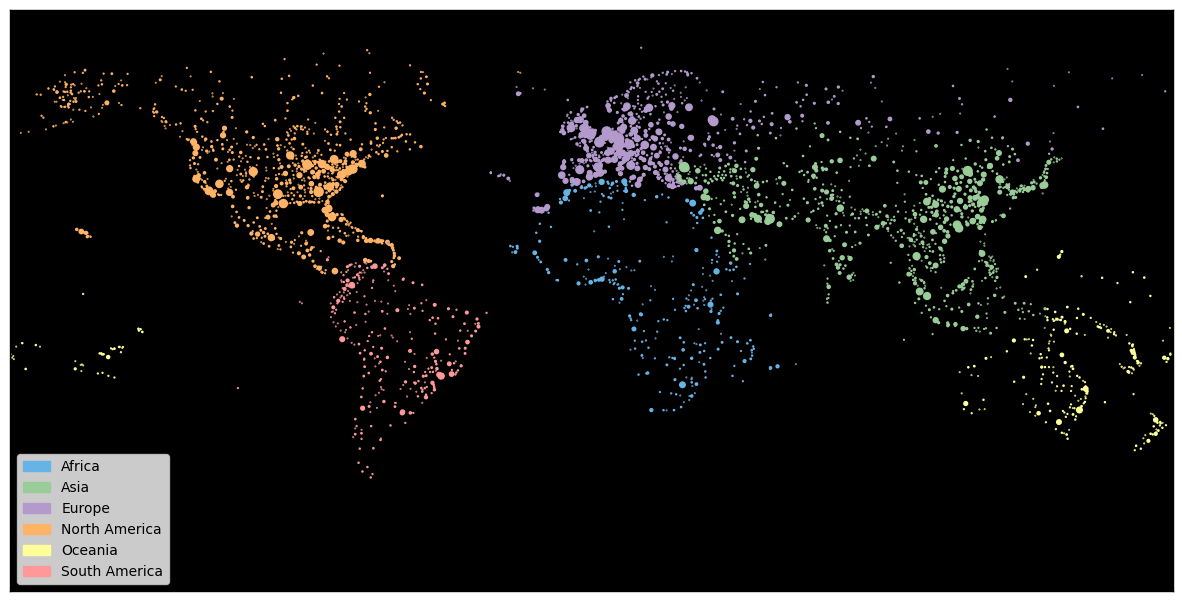

In [65]:
## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
m = Basemap(lon_0=0, resolution=resolution)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color="lightgrey", linewidth=0.3)

continent_to_color = {
    'Africa': (0.4, 0.7, 0.9), 
    'Asia': (0.6, 0.8, 0.6), 
    'Europe': (0.7, 0.6, 0.8), 
    'North America': (1.0, 0.7, 0.4), 
    'Oceania': (1.0, 1.0, 0.6), 
    'South America': (1.0, 0.6, 0.6)
    }

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
sizes = [0.2 * G_undirect.degree(node) for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
m.scatter(x, y, c=colors, s=sizes)
plt.legend(handles=[mpatches.Patch(color=continent_to_color[continent], label=continent) for continent in continent_to_color])
plt.savefig('images/flightmap_nodes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Tools, theory and analysis

### Working with text
It is important to know when the data was last updated. This is important for the analysis, as the data may be outdated.
It turns out that the review data spans from 2002 to 2015. This overlaps nicely with the flight data. 
This means that we hopefully can use the review data to predict the flight data. Although the review data is not completely up to date.

In [66]:
# check min and max of airportreviews "date" column. Only look at the first 4 characters of the date, as the year is the only relevant part
reviews = pd.read_csv('data/airportreviews.csv')
airports = pd.read_csv('data/airports_cleaned.csv')

print("Year of earliest review:", reviews['date'].str[:4].min())
print("Year of latest review: ", reviews['date'].str[:4].max())

Year of earliest review: 2002
Year of latest review:  2015


Let us look at some random reiews:

In [67]:
random_ints = np.random.randint(0, len(reviews), 5)
for i in random_ints:
    print("Airport:", reviews.loc[i, 'airport_name'])
    print("Content:", reviews.loc[i, 'content'])
    print("-" * 20)

Airport: delhi-airport
Content: Initial impressions are good. Indira Ghandi International Airport is a modern world class airport. However it is let down by the security. There are checks to get into the airport checks to get to check-in checks to get to passport control and the massive queues at passport control and through security. Whilst most modern airports and airlines suggest check-in 3 hrs before an international flight you need closer to 5 if you want to shop or use a lounge. It is ludicrous!
--------------------
Airport: bristol-airport
Content: The facilities were fair though snaking customs queues unnecessary. Duty Free shop offered goods found considerably cheaper on the high street. Boarding was reasonable although seating in the waiting area limited. Parking is highway robbery and taxis cost £42 return. I travelled again in May - an absolute nightmare. The snaking queues for customs were worse there was almost no available seating in the waiting areas - most space taken 

### Sentiment Analysis

As it will turn out later, wordclouds, TF, and TF-IDF will not be very informative for this task. This is because the reviews are too similar in subject matter and the communities simply do not differentiate themselves enough in the language used. The vocabulary being used is repetitive and is very narrow in it's scope. This is why we will use sentiment analysis to investigate the reviews. This will allow us a different insight from the reviews. The vader package is highly sofisticated and is able to detect the sentiment of a text. We will use this to analyze the reviews. The library is a pre-trained model that knows how to deal with negation, capitalization, emoticons, etc.. Therefore we will not tokenize or stem the text for this task. We will simply use the text as it is. We will use the compound score to determine the sentiment of the review. The compound score is a normalized score that ranges from -1 to 1 where -1 is a "very negative" text, and 1 is a "very positive" text. We will use this score to determine the sentiment of the review. Then it is easy to plot each community(continent) and see how the sentiment of the continents airports differ. There are 6 continents in this analysis with different amounts of reviews.
<br>
<br>
We will consider each continent as a community.

In [68]:
keys = ["North America", "Europe", "Africa","Oceania", "Asia", "South America"]

communities = {}
for continent in keys:
    airports_from_continent = airports[airports['continent'] == continent]
    reviews_from_continent = airports_from_continent["content"]
    reviews_from_continent = reviews_from_continent.dropna()
    reviews_from_continent = reviews_from_continent.apply(ast.literal_eval)
    ## reviews from continent is a list of lists
    ## flatten it out
    reviews_from_continent = [item for sublist in reviews_from_continent for item in sublist]
    communities[continent] = reviews_from_continent
    

It is a good idea to also consider the amount of data. Unfortunately, far most of the data is concentrated in Europe. Still, given the numbers below, we estimate that there is enough data for yielding results. To take into account the varying amount of data for each community, we have also calculated the error of our estimates for most of our results. 

In [69]:
spacing = 20
for continent, reviews in communities.items():
    string = f"{continent} has"
    print(string + "." * (spacing - len(string)), len(reviews), "reviews")

North America has... 188 reviews
Europe has.......... 3680 reviews
Africa has.......... 100 reviews
Oceania has......... 170 reviews
Asia has............ 321 reviews
South America has... 63 reviews


In [70]:
analyzer = SentimentIntensityAnalyzer()

sentiments = {}
for key in keys:
    sentiments[key] = []
    print("Analyzing sentiment for", key)
    for review in tqdm(communities[key]):
        sentiment = analyzer.polarity_scores(review)
        sentiments[key].append(sentiment['compound'])

Analyzing sentiment for North America


100%|██████████| 188/188 [00:00<00:00, 427.33it/s]


Analyzing sentiment for Europe


100%|██████████| 3680/3680 [00:07<00:00, 473.12it/s]


Analyzing sentiment for Africa


100%|██████████| 100/100 [00:00<00:00, 519.41it/s]


Analyzing sentiment for Oceania


100%|██████████| 170/170 [00:00<00:00, 527.22it/s]


Analyzing sentiment for Asia


100%|██████████| 321/321 [00:00<00:00, 545.73it/s]


Analyzing sentiment for South America


100%|██████████| 63/63 [00:00<00:00, 443.21it/s]


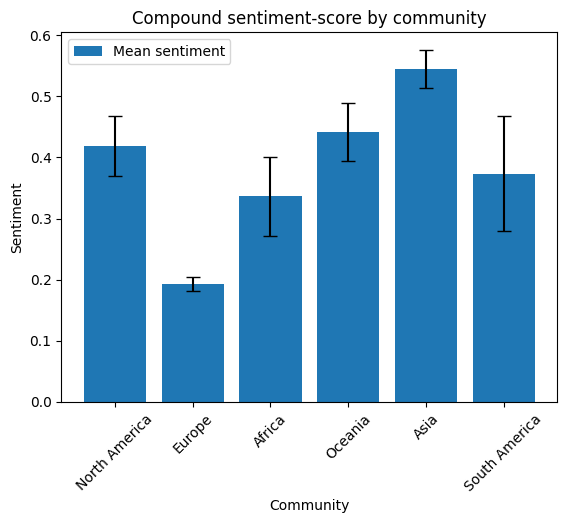

In [71]:
# plot the sentiments in the different communities
mean_sentiment = [np.mean(sentiments[key]) for key in sentiments.keys()]
uncertainty = [np.std(sentiments[key]) / np.sqrt(len(sentiments[key])) for key in sentiments.keys()]

## make bar plot with uncertainty
plt.bar(keys, mean_sentiment, yerr=uncertainty, capsize=5)
plt.ylabel('Sentiment')
plt.xlabel('Community')
plt.xticks(rotation=45)
plt.title('Compound sentiment-score by community')
plt.legend(['Mean sentiment'])
plt.savefig('images/sentiment.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

A natural question that arises is if the sentiment of the reviews merely describe the quality of the airport in the same way that the binary variable "recommended" does. This is an interesting question that will need to be checked out:

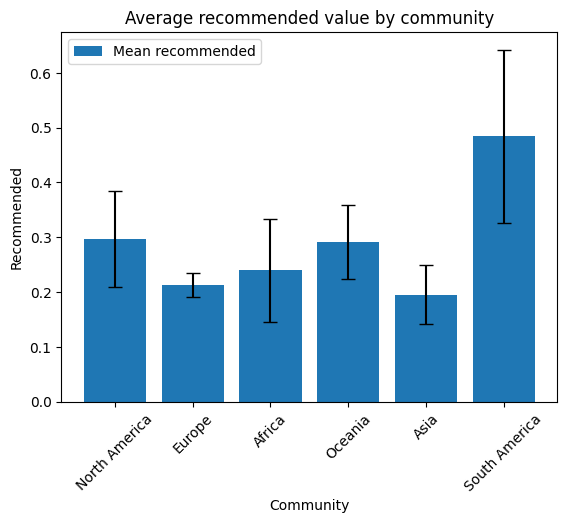

In [72]:
recommended = {}
for continent in keys:
    airports_from_continent = airports[airports['continent'] == continent]
    reviews_from_continent = airports_from_continent["average_recommendation"]
    reviews_from_continent = reviews_from_continent.dropna()
    recommended[continent] = reviews_from_continent
    

# plotting the average recommended value in the different communities
mean_recommendation = [np.mean(recommended[key]) for key in recommended.keys()]
uncertainty = [np.std(recommended[key]) / np.sqrt(len(recommended[key])) for key in recommended.keys()]
plt.bar(keys, mean_recommendation, yerr=uncertainty, capsize=5)
plt.ylabel('Recommended')
plt.xlabel('Community')
plt.xticks(rotation=45)
plt.title('Average recommended value by community')
plt.legend(['Mean recommended'])
plt.savefig('images/recommended.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

Interestingly, there is quite a difference in sentiment scores across different continents, but the average recommendation score is approximately the same. This might hint towards people having different expectations depending they are traveling. For example, people talk very highly of Asian airports, much higher than they do of European airports, but they get approximately the same score. 

As mentioned earlier, some of the "conventional methods" we have learned in the course are not the most informative in this specific case. Here is a showcase of some of them anyway:

$$
\text{{Lexical Diversity}} = \frac{{\text{{Number of unique words}}}}{{\text{{Total number of words}}}}
 $$

Calculating lexical diversity for South America: 100%|██████████| 63/63 [00:00<00:00, 731.53it/s]


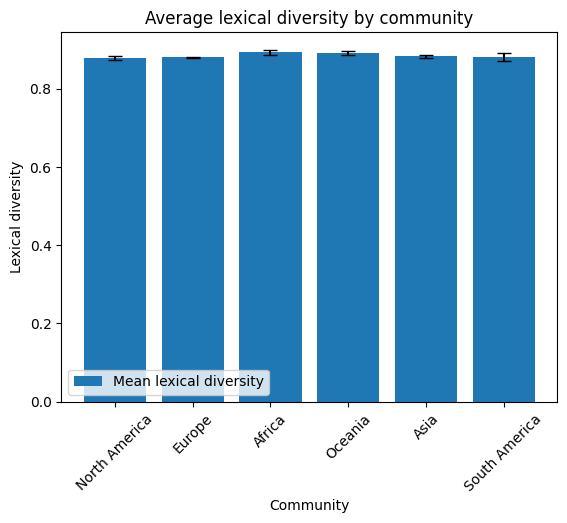

In [73]:
# Lexical diversity
def lexical_diversity(tokens):
    return len(set(tokens)) / len(tokens)

# Stemming
def stem(word):
     regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
     stem, suffix = re.findall(regexp, word)[0]
     return stem

# Tokenization + Stemming
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [stem(token) for token in tokens]
    return tokens

# What is the average lexical diversity of the reviews?
lexical_diversities = {}
for key in keys:
    lexical_diversities[key] = []
    for review in tqdm(communities[key], desc="Calculating lexical diversity for " + key):
        review = re.sub(r'[^\w\s]', '', review)
        review = review.lower()
        tokens = tokenize(review) 
        lexical_diversities[key].append(lexical_diversity(tokens))
        
mean_lexical_diversity = [np.mean(lexical_diversities[key]) for key in lexical_diversities.keys()]
uncertainty = [np.std(lexical_diversities[key]) / np.sqrt(len(lexical_diversities[key])) for key in lexical_diversities.keys()]
plt.bar(keys, mean_lexical_diversity, yerr=uncertainty, capsize=5)
plt.ylabel('Lexical diversity')
plt.xlabel('Community')
plt.xticks(rotation=45)
plt.title('Average lexical diversity by community')
plt.legend(['Mean lexical diversity'])
plt.savefig('images/lexical_diversity.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


 ### Making a dictionary of the tokenized and stemmed reviews.
Then we first take a look at Zipf's Law. It looks like exactly the textbook example. According to "https://en.wikipedia.org/wiki/Zipf%27s_law", Zipf's law hold for most natural language and is thus a good way to check if the textdata is natural language. The plot shows that the most common words are very common and the least common words are very rare. This inverse power-law structure is what the formula prescribes.

$$
f(k; s, N) = \frac{1/k^s}{\sum_{n=1}^{N} 1/n^s}
$$
where $f(k; s, N)$ is the frequency of the k-th most frequent word, $s$ is the distribution parameter, and $N$ is the total number of words in the document.

Tokenizing South America: 100%|██████████| 63/63 [00:00<00:00, 455.75it/s]


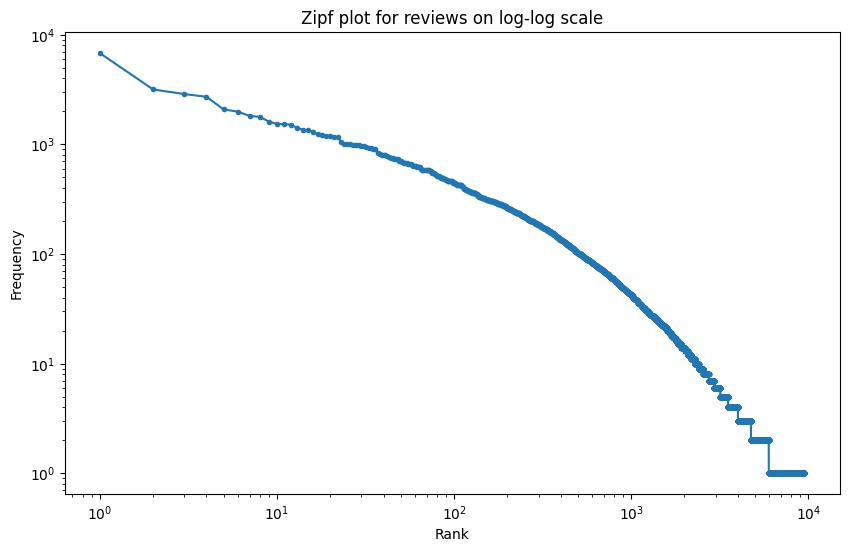

In [74]:
tokenized_communities = {}
for key in communities:
    tokenized_communities[key] = []
    for review in tqdm(communities[key], desc=f"Tokenizing {key}"):
        tokenized_communities[key].extend(tokenize(review))
    
# big community, all communities merged into one
big_community = []
for key in tokenized_communities:
    big_community.extend(tokenized_communities[key])

word_count = Counter(big_community)

# zipf plot on log log scale
plt.figure(figsize=(10, 6))
ranks = np.arange(1, len(word_count) + 1)
freqs = [f for w, f in word_count.most_common()]
plt.loglog(ranks, freqs, marker=".")
plt.title("Zipf plot for reviews on log-log scale")
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.savefig("images/zipf.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


Here we take a look at more of the aforementioned classical, yet in our case, not so informative methods. We will use wordclouds, TF, and TF-IDF to analyze the reviews. We will use the wordclouds to get a visual representation of the most common words in the reviews. 

$$
\text{{TF}} = \frac{{\text{{Number of times term t appears in a document}}}}{{\text{{Total number of terms in the document}}}}
$$

$$
\text{{IDF}} = \log\left(\frac{{\text{{Total number of documents}}}}{\text{{Number of documents with term t in it}}}\right)
$$

$$
\text{{TF-IDF}} = \text{{TF}} \times \text{{IDF}}
$$

In [75]:
from collections import defaultdict

def most_n_common_words(n, token_list): 
    word_count = Counter(token_list)
    return word_count.most_common(n)

def term_frequency(term : str, document_counted : Counter) -> float:
    """
    Function for calculating the term frequency of a term in a document.
    """
    
    return document_counted[term] / sum(document_counted.values())

def inverse_document_frequency(term : str, documents_counted : dict[Counter]) -> float:
    """
    Function for calculating the inverse document frequency of a term in a list of documents.
    """
    
    num_docs_with_term = sum([doc[term] > 0 for _, doc in documents_counted.items()])
    return np.log(len(documents_counted) / num_docs_with_term)

def tf_idf(term : str, document_counted : Counter, documents_counted : dict[Counter]) -> float:
    """
    Function for calculating the term frequency-inverse document frequency of a term in a document.
    """
    
    return term_frequency(term, document_counted) * inverse_document_frequency(term, documents_counted)

documents_counted = {}
for continent, tokens in tokenized_communities.items():
    documents_counted[continent] = Counter(tokens)

We apply the tf-idf approach on the reviews, but don't find any particular findings. Words such as "lga" (for North America) apparently scores high because it is only mentioned in North America (lga is a common abbreviation for LaGuardia airport in New York).

In [76]:
## calculate the tf-idf for each term in each document
## only look at the top 500 words in each document
tf_idfs = defaultdict(dict)
for continent, tokens in tokenized_communities.items():
    for term in tqdm(set(tokens), desc=f"Calculating tf-idf for {continent}"):
        tf_idfs[continent][term] = tf_idf(term, documents_counted[continent], documents_counted)

## for each continent, find the top 5 words in term of tf-idf
top_words_tfidf = {}
for continent in tf_idfs:
    top_words_tfidf[continent] = sorted(tf_idfs[continent], key=tf_idfs[continent].get, reverse=True)[:5]
    
print("")
for continent, words in top_words_tfidf.items():
    print(f"Top words in {continent}: {', '.join(words)}")

Calculating tf-idf for South America: 100%|██████████| 1358/1358 [00:00<00:00, 42203.78it/s]


Top words in North America: lga, palma, eze, manhattan, jfk
Top words in Europe: stanst, eu, train, edinburgh, bournemouth
Top words in Africa: newcastle, visa, fever, barrier, african
Top words in Oceania: pdx, portland, newcastle, jetstar, albany
Top words in Asia: changi, garden, fukuoka, singapore, internet
Top words in South America: macau, kong, hong, dabolim, goa


Below, we investigated some of the highest scoring terms with regards to TF-IDF. This is a good sanity check, to see if the found terms even makes sense (for example, what is "pdx", the no.1 highest scoring term for Oceania?).

In [77]:
def view_strings_with_term(term : str, strings : list[str]):
    """
    Function for viewing strings that contain a term.
    """
    
    for string in strings:
        string = string.lower()
        if term in string:
            index = string.index(term)
            start_index = max(0, index - 50)
            end_index = min(len(string), index + 50)
            substring = string[start_index:end_index]
            padded_substring = "." * (50 - index) + substring
            padded_substring = padded_substring + "." * (100 - len(padded_substring))
            print(padded_substring)
            
term = " lga"
print(f"The reviews with the term '{term}' in North America \n")
view_strings_with_term(term, communities["North America"])

The reviews with the term ' lga' in North America 

.arrived and departed from the central terminal at lga recently and was blown away by the terminal. 
.............................................using lga is like a trip back to the seventies in some 
...............................flown in and out of lga domestically. used terminal b (the main termi
irty. i would never recommend anyone to travel via lga..............................................
of choice didn't have any jfk flights available so lga was the only choice as ewr would be way too f
.....................................in and out of lga may 2011. coming in no problems baggage claim
it's after mid day there will always be a delay at lga. there are not enough seats at the gates and 
ll not let you book a flight online into or out of lga jfk or ewr without showing a warning that the
 and out on air canada over christmas. flight into lga from toronto was subject to a 3.5 hour ground
.......................................

In [78]:
term = " pdx"
print("The reviews with the term 'pdx' in Oceania \n")
view_strings_with_term(term, communities["Oceania"])

The reviews with the term 'pdx' in Oceania 

................i'm a big fan and frequent user of pdx. i can't comment on pax drop-off as i usually
ut portland international airport. first the good: pdx has a lot of restaurants and shops to visit. 
.............i cannot say enough good things about pdx. the ticketing lobby is open and airy. the bo
..........................i fly frequently through pdx sometimes several times per month depending u
y to pick up passengers in the handicapped zone at pdx (what a joke that turned out to be) since i m
.................................connected through pdx enroute to canada and was disappointed to fin
out $70 parking tickets like candy. i travel alot- pdx is the worst with this in the entire country.
.................i live in portland and fly out of pdx a couple times a year. tsa have always been n
...............................i connected through pdx on my way from fra to yvr. overall as far as 
......................................i would 

### Wordclouds
Now we can try wordclouds for each community. We can see that the wordclouds are very similar for all communities. 

Creating wordclouds: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


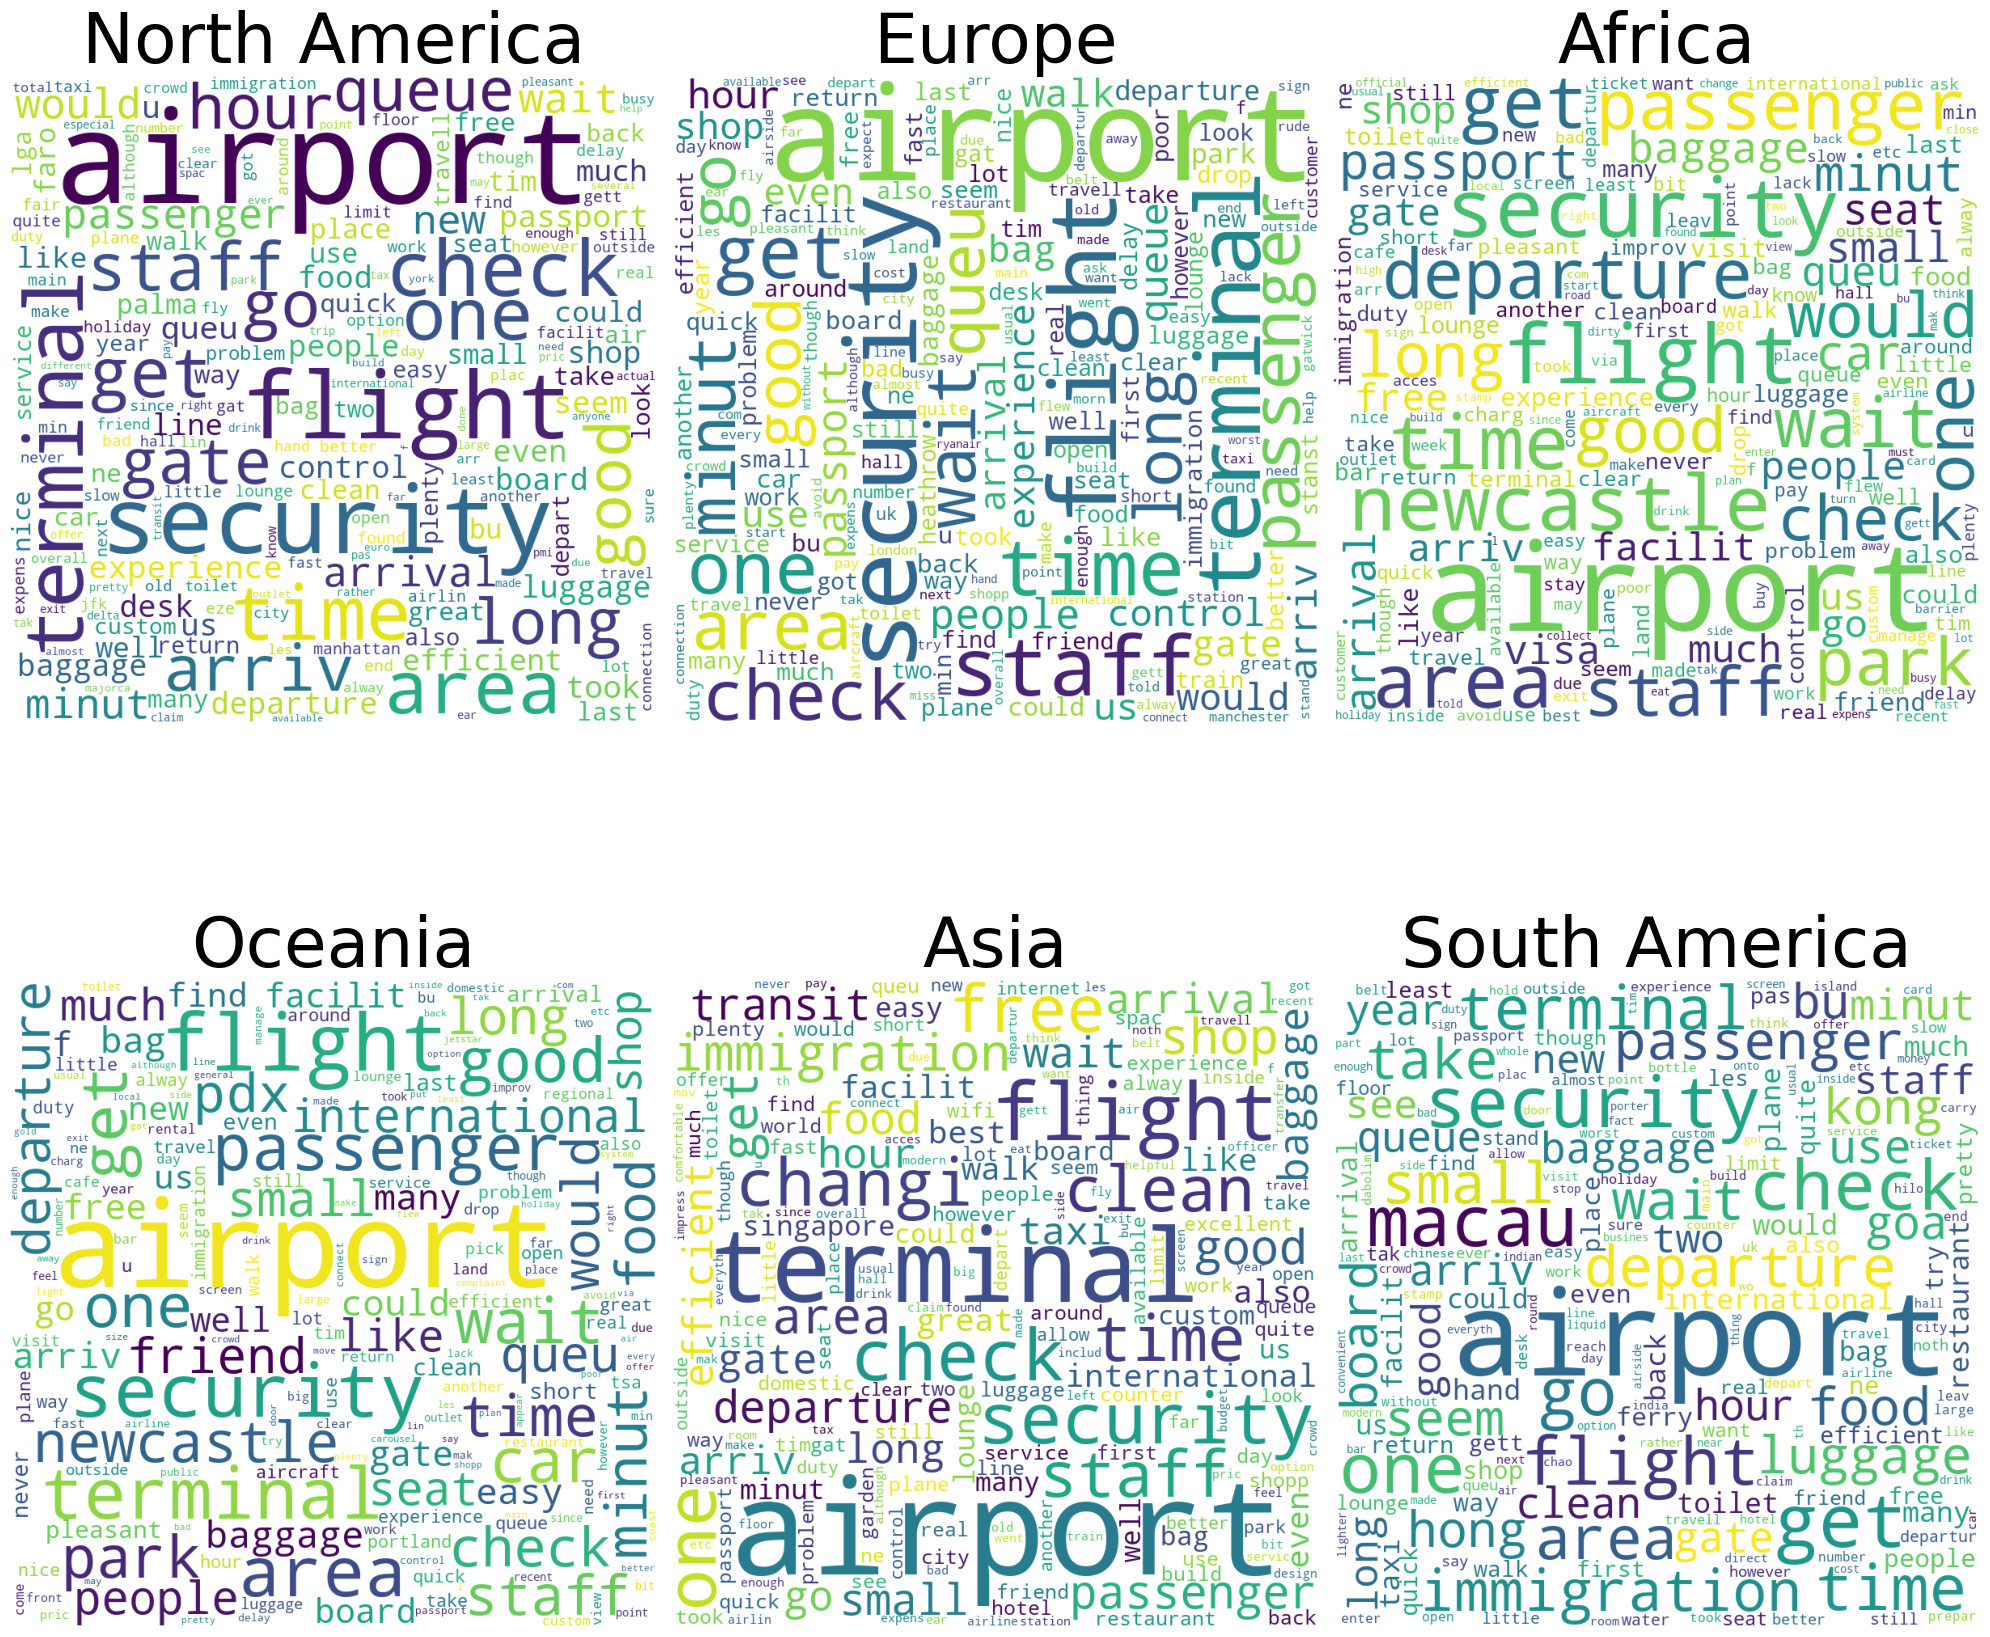

In [79]:
fig, axs = plt.subplots(2, 3, figsize=(20, 20)) 
for i, community in tqdm(enumerate(tokenized_communities), desc="Creating wordclouds", total=len(tokenized_communities)):
    ax = axs[i // 3, i % 3]
    word_freq = documents_counted[community]
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
    ax.imshow(wordcloud)
    ax.axis("off")

    ax.set_title(community, fontsize=50)


plt.tight_layout()
plt.savefig("images/wordclouds.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

It could be the case that the top 10 most common words are "diluting" / " polluting" the wordclouds. We can try to remove these words and see if the wordclouds become more informative.

Creating wordclouds: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


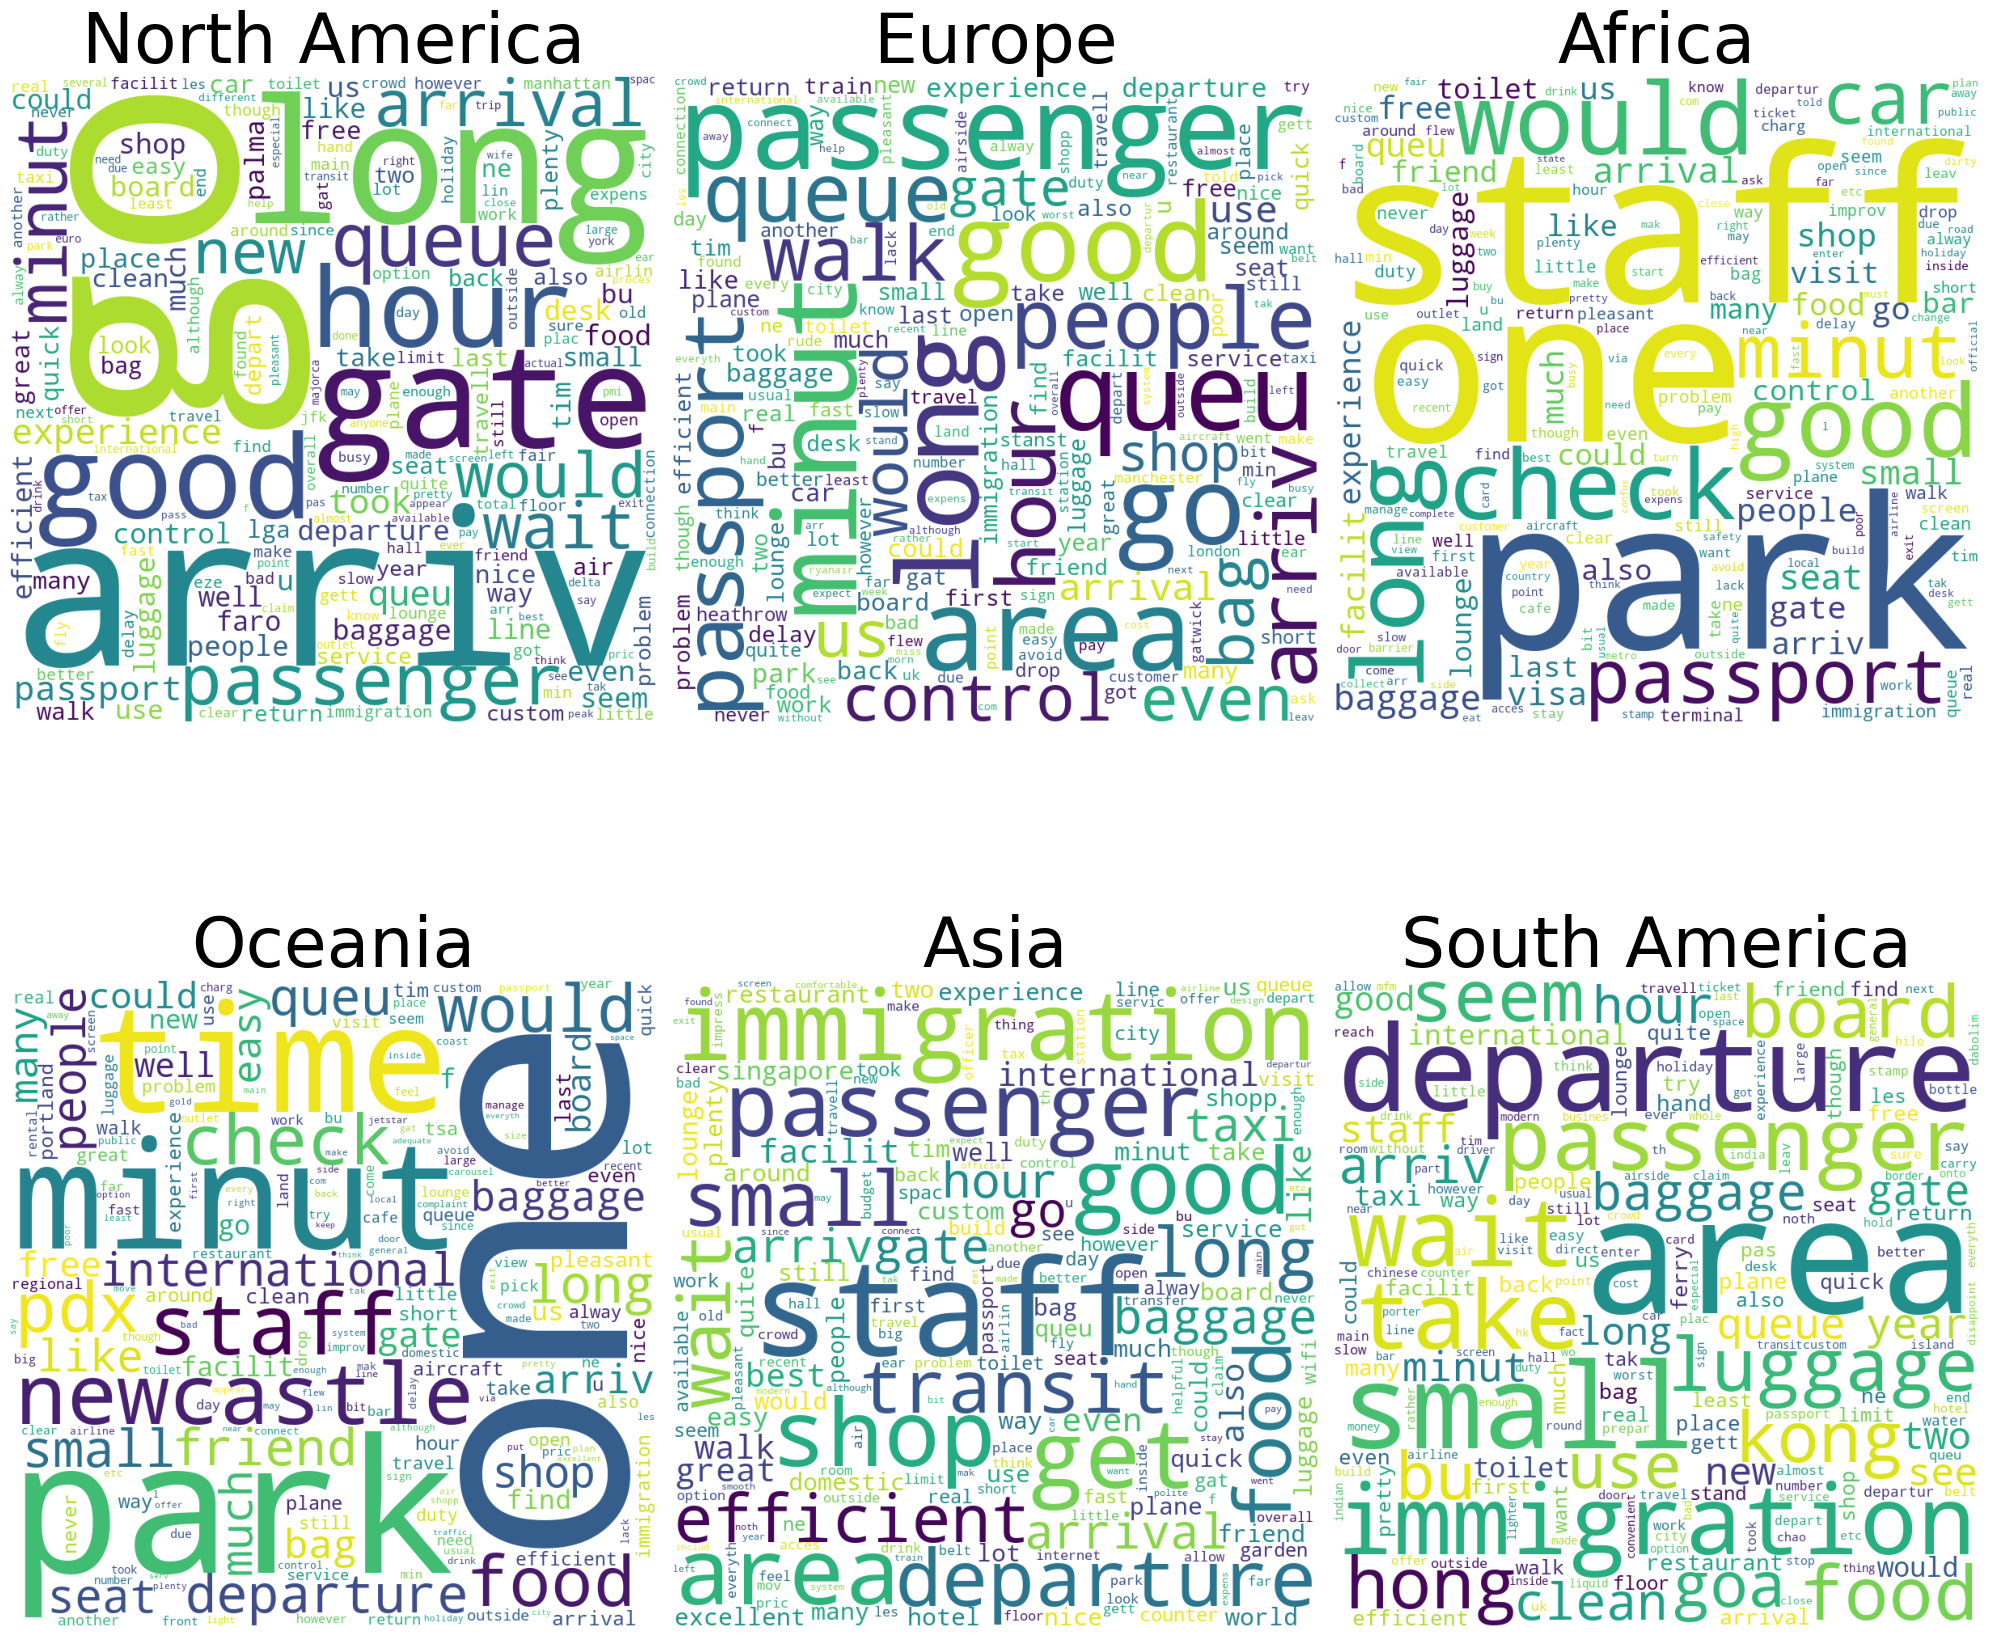

In [80]:
topk = 10

documents_counted_no_top = {}
for continent, counter in documents_counted.items():
    most_common = dict(counter.most_common(topk))
    new_counter = Counter({word: count for word, count in counter.items() if word not in most_common})
    documents_counted_no_top[continent] = new_counter

fig, axs = plt.subplots(2, 3, figsize=(20, 20)) 
for i, community in tqdm(enumerate(documents_counted_no_top), desc="Creating wordclouds", total=len(documents_counted_no_top)):
    ax = axs[i // 3, i % 3]
    word_freq = documents_counted_no_top[community]
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
    ax.imshow(wordcloud)
    ax.axis("off")

    ax.set_title(community, fontsize=50)


plt.tight_layout()
plt.savefig(f"images/wordclouds_no_top_{topk}.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

The wordclouds do not become noticably more explanatory. 
To wrap things up we can say that based on the testimonials from thousands of different passengers spanning the period from 2002-2015 in airports all across the world, the sentiment of the reviews are largely positive. There are some communities(continents) that seem to garner more positive reviews than others.

We noted the following interesting findings: 
* We find that the textual reviews follows Zipf's law, therefore we can confidently say that the textual reviews are actual human reviews. 
* We find that South America has the highest average recommendation level, though with a big uncertainty.
* Oceania has the lowest average recommendation level.
* We find that Asia has the highest sentiment score, i.e. people are talking more positively about airports in Asia. 
* Europe has the lowest sentiment score. 

### Visualizing the numerical ratings
We really wanted to visualize how the airports around the globe is rated based on the numerical reviews. That is, not only how they are performing in each community, but how they perform in any given set of coordinates.<br>
The numerical reviews are binary, either 1 or 0. <br>
 We wanted to paint the whole worldmap depending on the quality of aiports in the different regions. We considered multiple ways of doing it, and we ended up agreeing on doing regression to interpolate this score based on nearby airports using a Gaussian Process. 
The good thing about a Gaussian Process is that it also reports an error in each point, and we can therefore color in areas where the regression model in uncertain about the target value. This would be places where there is no airport close by with any reviews. 

So, we made two functions, one for fitting a Gaussian Process to the (x,y) coordinates, and one for plotting the results.

In [81]:
def fit_gp(X, y, alfa_uncertainty = 0.1, resolution=1000, length_scale=5):
    kernel = RBF(length_scale=length_scale, length_scale_bounds="fixed")
    model = GaussianProcessRegressor(kernel=kernel, alpha=alfa_uncertainty, normalize_y=True)
    model.fit(X, y)

    lats, lons = X[:, 0], X[:, 1]
    min_lats, max_lats = -90, 90
    min_lons, max_lons = -180, 180

    lats = np.linspace(min_lats, max_lats, resolution)
    lons = np.linspace(min_lons, max_lons, resolution)
    lats, lons = np.meshgrid(lats, lons)
    Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
    ymesh, uncertainty = model.predict(Xmesh, return_std=True)
    uncertainty = uncertainty.reshape((resolution, resolution))
    ymesh = ymesh.reshape((resolution, resolution))
    
    return lons, lats, ymesh, uncertainty

def visualize_gp(lons, lats, ymesh, uncertainty, max_uncertainty, title="", label=""):
    ## make a grey cmap, that always returns grey
    min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
    
    cmap_grey = LinearSegmentedColormap.from_list(
        "grey", 
        [(min_ymesh, "grey"), (max_ymesh, "grey")]
    )
    
    c = ["red","orange","yellow","palegreen","green","darkgreen"]
    cmap=LinearSegmentedColormap.from_list('rg',c, N=256)
    m = Basemap(lon_0=0)
    
    def is_water(lat, lon):
        return not m.is_land(lon, lat)

    resolution, _ = ymesh.shape
    try: 
        ywater = np.load(f"data/ywater{resolution}.npy")
    except:
        ywater = np.zeros_like(ymesh)
        for i in tqdm(range(ymesh.shape[0])):
            for j in range(ymesh.shape[1]):
                if is_water(lats[i, j], lons[i, j]):
                    ywater[i, j] = 1
        np.save(f"data/ywater{resolution}.npy", ywater)
        
    watermasked = np.ma.masked_where(ywater == 1, ymesh)
    uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
    m.colorbar(location="bottom", label=label)
    m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
    grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')
    plt.legend(handles=[grey_patch])
    plt.title(title)
    plt.savefig(f'images/{title}', dpi=300, bbox_inches='tight')
    plt.show()

When fitting a GP model, we also need to assign $\alpha$-values to each point estimate. The $\alpha$-value pertaining to a point is the uncertainty in that point, more specifically, it is the variance of the estimate in that point. Since we are estimating the level of recommendation on a sample size $N$ (the number of reviews for a given airport), and since the value can fall somewhere between 0 and 1, it makes sense to model the recommendation level as a beta distribution, and calculate the $\alpha$ values as the variance of the distribution. 

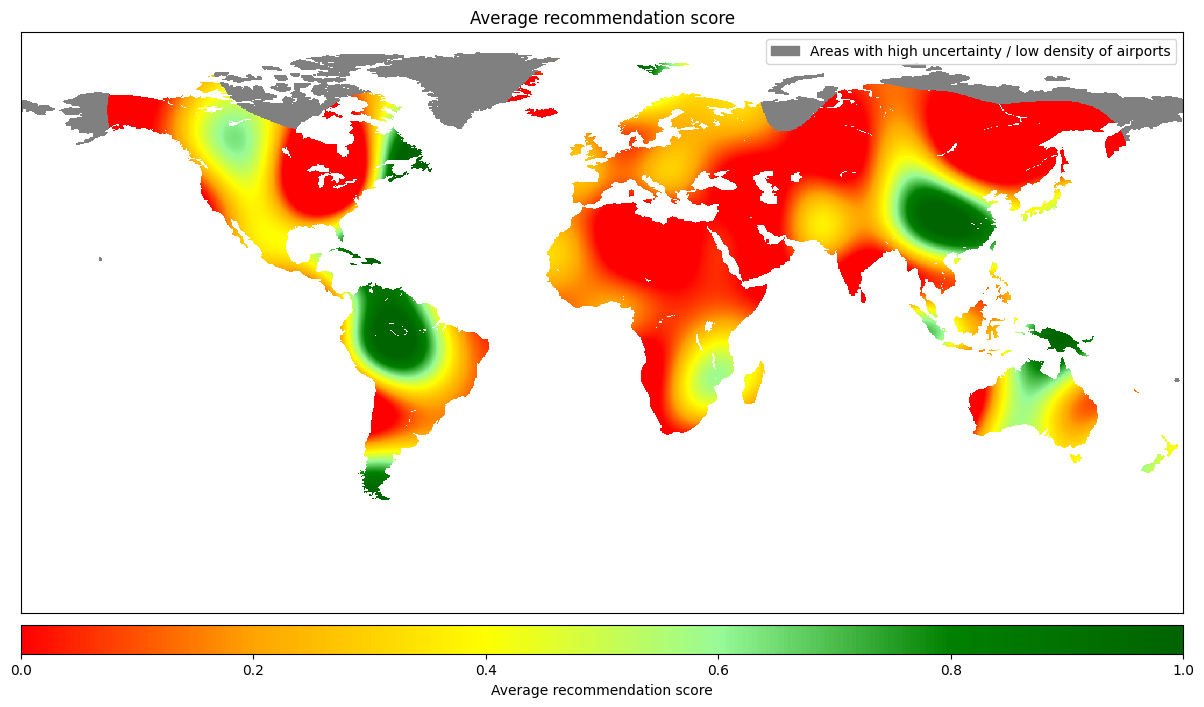

In [82]:
airports = pd.read_csv("data/airports_cleaned.csv")
airports_all_reviews = airports.dropna(subset=["average_recommendation"])
X_coordinates = airports_all_reviews[["latitude", "longitude"]].to_numpy()
number_of_reviews = airports_all_reviews["number_of_reviews"].to_numpy()
avg_rec = airports_all_reviews["average_recommendation"].to_numpy()
alfa, beta = number_of_reviews * avg_rec + 1, number_of_reviews * (1 - avg_rec) + 1
## the formula for the variance of a beta distribution
## can be used to estimate point uncertainty in the GP model, i.e. how sure are we of the target value that is attributed to that point?
beta_dist_var = alfa * beta / ((alfa + beta) ** 2 * (alfa + beta + 1)) 

lons, lats, ymesh, uncertainty = fit_gp(X_coordinates, avg_rec, beta_dist_var, length_scale=15, resolution=1000)
max_rec_uncertainty = np.percentile(uncertainty, 50)
ymesh = np.clip(ymesh, 0, 1) ## make sure the values are between 0 and 1. the GP (falsely) can predict values outside this range
visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty, 
    max_rec_uncertainty, 
    title="Average recommendation score", 
    label="Average recommendation score"
    )

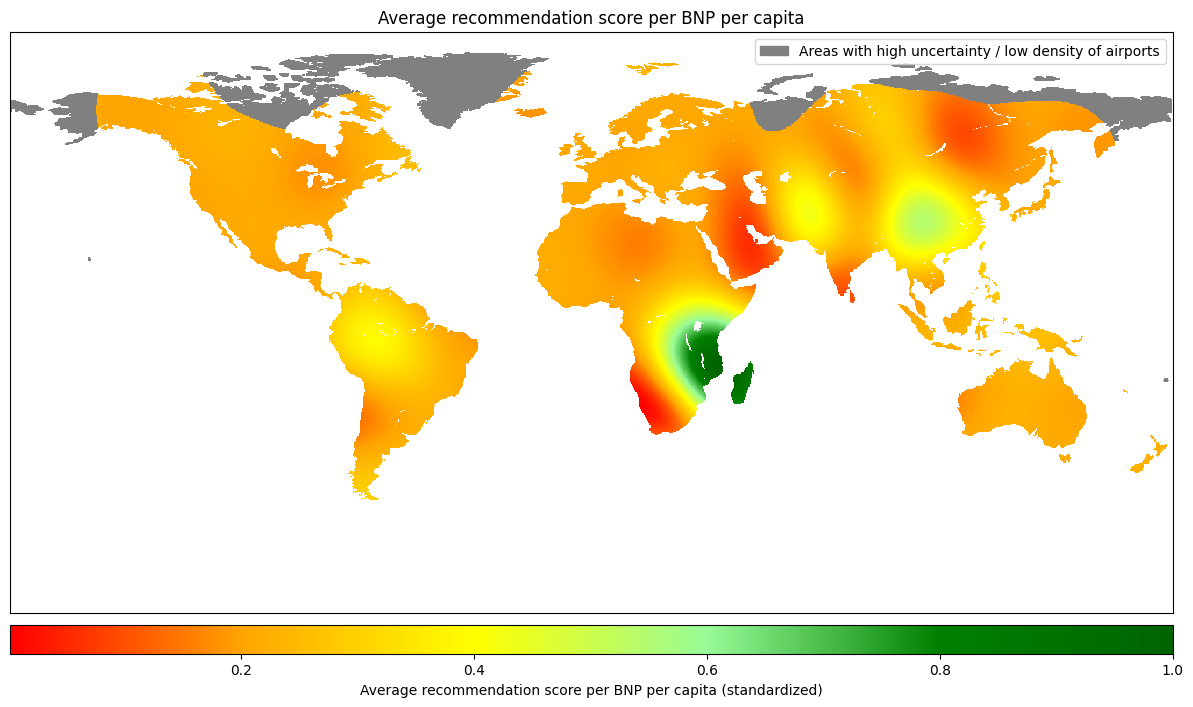

In [83]:
avg_rec_per_bnp = airports_all_reviews["recommended_BNP_ratio"].to_numpy()

lons, lats, ymesh, _ = fit_gp(X_coordinates, avg_rec_per_bnp, beta_dist_var, length_scale=15, resolution=1000)
## standardize ymesh between 0 and 1. dont clip it
min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
ymesh = (ymesh - min_ymesh) / (max_ymesh - min_ymesh)

visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty,            ## use same uncertainty and max uncertainty as before 
    max_rec_uncertainty,    ## -||-
    title="Average recommendation score per BNP per capita", 
    label="Average recommendation score per BNP per capita (standardized)"
    )

### Where are the good airports?

We can inspect the above plot can conclude the following:
* Most airports are very poorly rated all over the world. 
* Highly rated airports are not neccesarily placed in developing countries, but seems scattered all over the globe. But in particular, large areas of South America are "green". This is consistent with the findings in the prior analysis of the different communities. 
* A few airports in south east Africa seems to severely outperforming all other airports in terms of rating per BNP per capita.
* Most countries are "orange/yellow" when adjusted for BNP, i.e. they perform equally well when adjusted for BNP.

Below, we'll look at the top 5 best rated airports, and top 5 best rated when adjusted for BNP. We'll also show pictures from these airports. We will only inspect airports with more than 10 reviews.

In [86]:
topk = 5
min_num_reviews = 5

cols_to_show = ["id", "country", "BNP per capita", "average_recommendation", "recommended_BNP_ratio", "number_of_reviews"]
## we only look at airports with more than x reviews
airport_best_avg_rec = airports_all_reviews[airports_all_reviews["number_of_reviews"] > min_num_reviews].sort_values("average_recommendation", ascending=False).iloc[:topk]
print(f"Top {topk} airports with the best average recommendation score:")
## pretty print the dataframe
airport_best_avg_rec[cols_to_show].head()

Top 5 airports with the best average recommendation score:


id         country  BNP per capita  \
412           Southend Airport  United Kingdom    44948.336000   
403           Guernsey Airport        Guernsey    32323.240342   
2533  Singapore Changi Airport       Singapore    89160.730000   
809      Fuerteventura Airport           Spain    37373.950000   
1741           Fukuoka Airport           Japan    40402.582000   

      average_recommendation  recommended_BNP_ratio  number_of_reviews  
412                 0.655172               1.299618               29.0  
403                 0.571429               1.576234                7.0  
2533                0.558011               0.558011              181.0  
809                 0.444444               1.060284                9.0  
1741                0.428571               0.945775               14.0

# Top 5 scoring airports (recommendation)
### Southend Airport, England
![southend](images/airport_images/southend.jpg)
### Guernsey Airport, Guernsey
![guernsey](images/airport_images/guernsey.jpg)
### Singapore Changi Airport, Singapore
![singapore](images/airport_images/singapore.jpg)
### Fuerteventura Airport, Spain
![fuerteventura](images/airport_images/fuerteventura.png)
### Fukuoka Airport, Japan
![fukuoka](images/airport_images/Fukuoka.jpg)

In [87]:
airport_best_avg_rec_per_bnp = airport_best_avg_rec = airports_all_reviews[airports_all_reviews["number_of_reviews"] > min_num_reviews].sort_values("recommended_BNP_ratio", ascending=False).iloc[:topk]
print(f"Top {topk} airports with the best average recommendation score per BNP per capita:")
airport_best_avg_rec_per_bnp[cols_to_show].head()

Top 5 airports with the best average recommendation score per BNP per capita:


id       country  BNP per capita  average_recommendation  \
3966  Hyderabad Airport      Pakistan     4552.605500                0.333333   
1813   San Jose Airport   Philippines     7235.081500                0.235294   
624   Newcastle Airport  South Africa    13887.211000                0.302632   
403    Guernsey Airport      Guernsey    32323.240342                0.571429   
944      Zagreb Airport       Croatia    24931.486000                0.380952   

      recommended_BNP_ratio  number_of_reviews  
3966               6.528183               24.0  
1813               2.899621               34.0  
624                1.943000               76.0  
403                1.576234                7.0  
944                1.362373               21.0

# Top 5 scorings airports (recommendation per BNP)
### Hyderabad Airport, Pakistan
![hyderabad](images/airport_images/hyderabad.jpg)
### San Jose Airport, Philippines
![sanjose](images/airport_images/san%20jose.jpg)
### Newcastle Airport, South Africa
![newcastle](images/airport_images/newcastle.jpg)
### Guernsey Airport
![Guernsey](images/airport_images/guernsey.jpg)
### Zagreb Airport
![Zagreb](images/airport_images/zagreb.jpg)

### Analysing reviews with graph theory
Next up, we want to look at the actual graph over flight connections and analyze it using graph theory. 

This will be our other method for determining what a good airport is: is it well connected? And is it connected to other good airports?

First, we want to make a smaller graph which consists of a subset of nodes, that is those nodes which have a rating. We make this small graph only with reviews to better analyse the airports with ratings. This will be handy later.

In [88]:
with open('data/graphnetwork.gpickle', 'rb') as f:
    G : nx.Graph = pickle.load(f)

airports_with_reviews_IATA = airports_with_reviews["IATA"].to_list()
## make a subgraph of the airports with reviews
G_reviews = G.subgraph(airports_with_reviews_IATA)
G_reviews = nx.Graph(G_reviews)
print("Number of nodes in subgraph:", G_reviews.number_of_nodes())

## save the subgraph to a file
with open('data/graphnetwork_reviews.gpickle', 'wb') as f:
    pickle.dump(G_reviews, f, pickle.HIGHEST_PROTOCOL)
    print("Saved subgraph to file")

Number of nodes in subgraph: 176
Saved subgraph to file


In [2]:
## load in the data AGAIN
## in case you want to run the notebook from here

with open('data/IATA.json') as f:
    IATA = json.load(f)
    
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

with open('data/graphnetwork_reviews.gpickle', 'rb') as f:
    G_review = pickle.load(f)

The first thing we do to get a crip of the network are to look at the degree distribution, average, median, mode, minimum, maximum degree of the nodes, connectedness, isolated nodes. This will provide us with the basic insids of the project. 

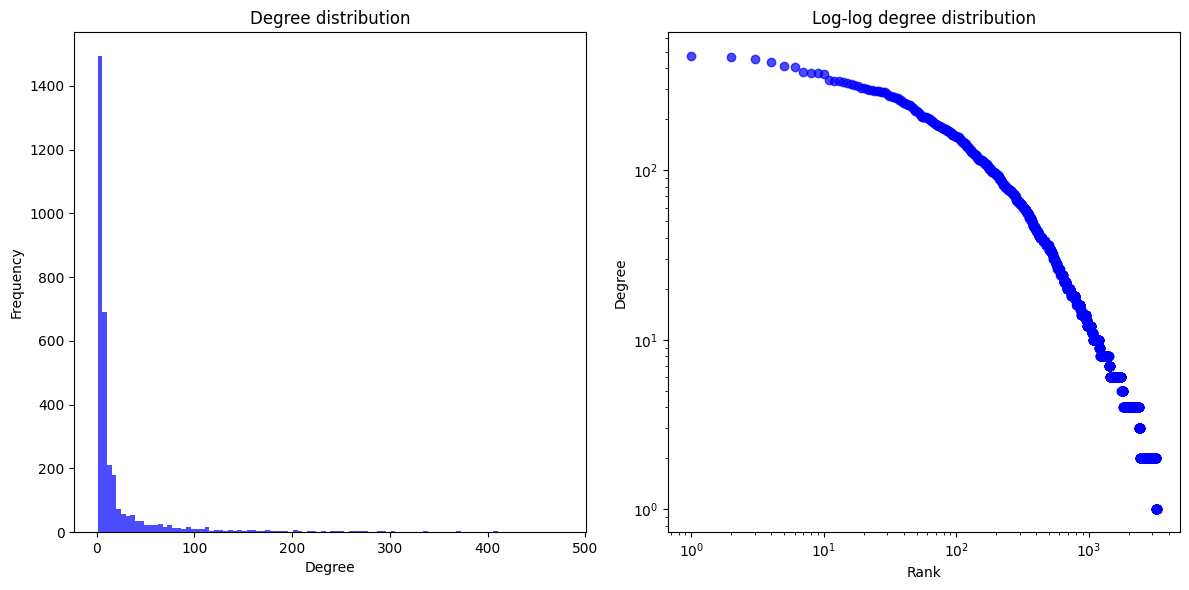

Average degree: 22.75061425061425
Median degree: 6.0
Mode degree: 2
Minimum degree: 1
Maximum degree: 477
Is the graph connected: False
Number of strongly connected components: 48
Number of weakly connected components: 7
Average clustering coefficient: 0.47450043644877804
Network density: 0.0034947180108470433
In supercitical regime: True 0.0069894360216940865


In [90]:
#Degree distribution of the network
degrees = [d for n, d in G.degree()]
#Degree distribution as histogram and log-log scatter plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(degrees, bins=100, color='blue', alpha=0.7)
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Degree distribution')
ax[1].loglog(sorted(degrees, reverse=True), 'o', color='blue', alpha=0.7)
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('Degree')
ax[1].set_title('Log-log degree distribution')
plt.tight_layout()
plt.show()

#Find the average, median, mode, minimum, maximum degree of the nodes
print('Average degree:', np.mean(degrees))
print('Median degree:', np.median(degrees))
print('Mode degree:', max(set(degrees), key=degrees.count))
print('Minimum degree:', min(degrees))
print('Maximum degree:', max(degrees))

#Find connectedness of the directed graph
print('Is the graph connected:', nx.is_strongly_connected(G))
print('Number of strongly connected components:', nx.number_strongly_connected_components(G))
print('Number of weakly connected components:', nx.number_weakly_connected_components(G))

#Clustering coefficient
clustering = nx.average_clustering(G)
print('Average clustering coefficient:', clustering)


#network density
density = nx.density(G)
print('Network density:', density)

#Checks which regime the graph is in
size = len(G.nodes())
num_edges = len(G.edges())
p = (2 * num_edges) / (size * (size - 1)) #Equation 3.2 in the Network Science book.
print("In supercitical regime:", p > 1 / size,p) #Formula from section 3.6 in the Network Science book.

### What can we say about this:

At first, we see a skewness of the degree distribution, this indicates that there exists a lot of airports of few well-connected airports. And that the majority have few connections, heavy-tail behavior was ecpected sinces it is a real-world graph. This aligns well with the spoke–hub distribution paradigm (https://en.wikipedia.org/wiki/Spoke%E2%80%93hub_distribution_paradigm) which is important in transport networks. The log-log plot further emphasizes that our graph follows a power-law distribution and the graph also says that there are few nodes (airports) with very high connectivity. These must function as major international traveling hubs, which means that they connect many airports and have an important role as a bridge between them.
When we look at the different values of the degree we see that there is a huge variation between the minimum degree and the maximum degree. This plays into our idea that there exist few major transport hubs. The graphs are not connected and do therefore have a disconnected nature, this means that there exist some airports that are connected in a cluster, but not the the rest of the network. This led us to see if we succeded in removing all isolated airports, which we have. The difference in the Average, Median, and Mode, is due to the highly influential airports that have many connections.
If we look at the average clustering coefficient, we see a moderately high value. The value indicates that there is local clustering, this could have something to do with the region it is in and the neighbors. The low density suggests that not all possible connection is used, and the network is therefore sparsely connected, but with the clustering coefficient, it means that there are clusters that are well connected.
At last, the graph is in the supercritical regime. This aligns with the general observation that real networks do fall into the supercritical regime and have passed the critical point.


The formula for p-value: $$p = \frac{2 \cdot|L|}{N \cdot (N - 1)}$$


### Investigate the centrality

The next step is to look at the centrality measures: Closness, Eigenvector and betweenness centrality. This will tell us how well the airports are connected, and if the degree has an influence on it.

Calculating closeness centrality...
Calculating eigenvector centrality...
Calculating betweenness centrality...


Calculating composite score: 100%|██████████| 3256/3256 [00:00<00:00, 1084205.61it/s]


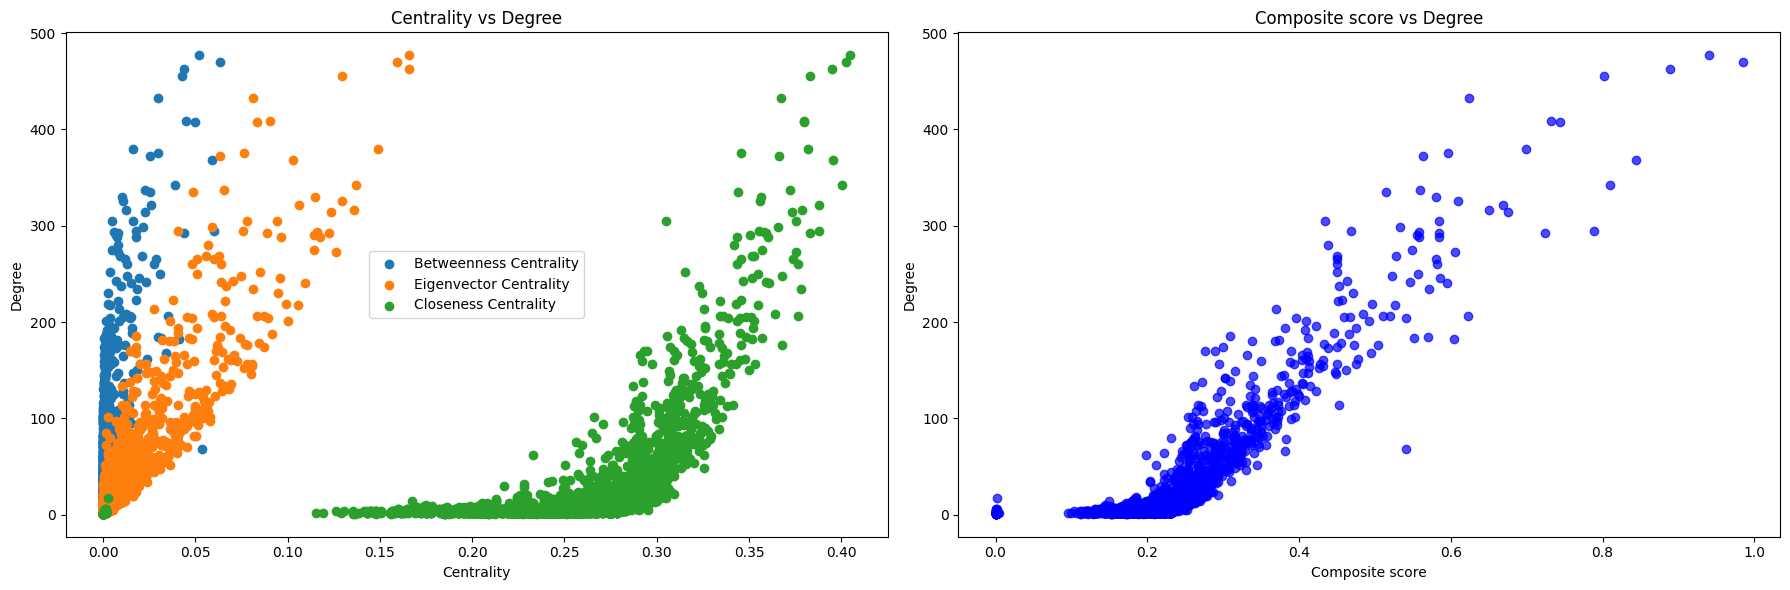

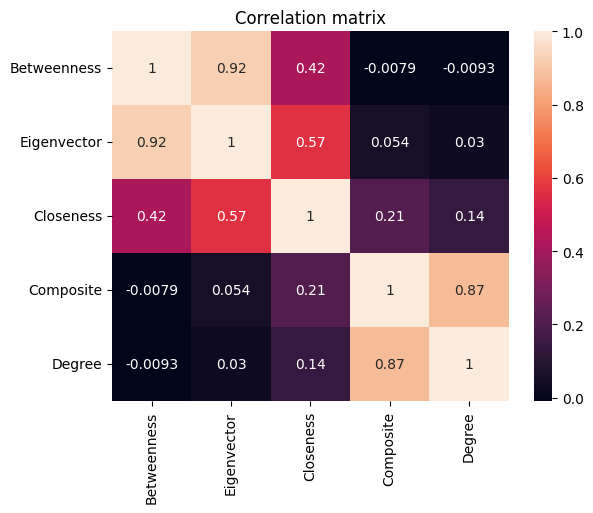

In [3]:
#Find the centrality of the graph and sort them
print("Calculating closeness centrality...")
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Calculating eigenvector centrality...")
eigenvevtor_centrality = nx.eigenvector_centrality(G)
sorted_eigenvevtor_centrality = sorted(eigenvevtor_centrality.items(), key=lambda x: x[1], reverse=True)
print("Calculating betweenness centrality...")
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Normalizing centrality values
max_closeness = max(closeness_centrality.values())
max_eigenvector = max(eigenvevtor_centrality.values())
max_betweenness = max(betweenness_centrality.values())

airport_composite_score = {}
for node in tqdm(G.nodes, desc='Calculating composite score'):
    normalized_closeness = closeness_centrality[node] / max_closeness
    normalized_eigenvector = eigenvevtor_centrality[node] / max_eigenvector
    normalized_betweenness = betweenness_centrality[node] / max_betweenness
    
    #Calculating composite score with equal weighting
    composite_score = (normalized_closeness + normalized_eigenvector + normalized_betweenness) / 3
    airport_composite_score[node] = composite_score

#Sorting airports by composite score
sorted_composite_score = sorted(airport_composite_score.items(), key=lambda x: x[1], reverse=True)

#A scatter plot for centrality measurements vs degree besids the composite score against degree
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].scatter([v for k, v in sorted_betweenness_centrality], [G.degree(k) for k, v in sorted_betweenness_centrality], label='Betweenness Centrality')
axs[0].scatter([v for k, v in sorted_eigenvevtor_centrality], [G.degree(k) for k, v in sorted_eigenvevtor_centrality], label='Eigenvector Centrality')
axs[0].scatter([v for k, v in sorted_closeness_centrality], [G.degree(k) for k, v in sorted_closeness_centrality], label='Closeness Centrality')
axs[0].set_xlabel('Centrality')
axs[0].set_ylabel('Degree')
axs[0].set_title('Centrality vs Degree')
axs[0].legend()
axs[1].scatter([airport_composite_score[n] for n in G.nodes()], [d for n, d in G.degree()], color='blue', alpha=0.7)
axs[1].set_xlabel('Composite score')
axs[1].set_ylabel('Degree')
axs[1].set_title('Composite score vs Degree')
plt.tight_layout()
plt.show()


#Find correlation between centrality measurements, composite score and degree
df = pd.DataFrame({'Betweenness': [v for k, v in sorted_betweenness_centrality],
                   'Eigenvector': [v for k, v in sorted_eigenvevtor_centrality],
                   'Closeness': [v for k, v in sorted_closeness_centrality],
                   'Composite': [airport_composite_score[n] for n in G.nodes()],
                   'Degree': [d for n, d in G.degree()]})
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()

### What can we say about this:

Composit formula: $$Composite\space centrality=\frac{1}{3} \cdot (\frac{CC(n)}{max(CC(n))|n\in G}+\frac{EC(n)}{max(EC(n)|n\in G)}+\frac{BC(n)}{max(BC(n))|n\in G})$$
CC = CLoseness Centrality, EC = Eigenvector centrality, BC = Betweeness centrality

On the scatter plot the closeness centrality is somehow positively correlated with the degree. The closeness centrality says something about how fast information spreads in the graph and depends on how many connections the airport has. The positive correlation means that airports with more connections tend to be more central and therefore are a critical point for efficiency of transport.
The eigenvector centrality seems to be quite linear and positively correlated. However, the spread of values with the airports of high degree means that even airports with less degree can influence the network due to them being connected to other major hubs.
When it comes to the betweenness centrality (https://en.wikipedia.org/wiki/Betweenness_centrality), which tells if an airport lies on paths between other airports, we do not see a clear tendency. This amplifies the tendency in eigenvector centrality because nodes with a moderate degree still have importance in the connection between different parts of the network.
To combine this result we use the composite index where every centrality is weighted equally, what we see is that there is a linear tendency between composite score and the amount of degree.

In [6]:
#Top 20 airports by composite score
print('Top 20 airports by composite score:')
for i, (airport, score) in enumerate(sorted_composite_score[:20]):
    name, continent = IATA[airport]['name'], IATA[airport]['continent']
    print(f'{i + 1}. {name}, {continent} ({score:.2f})')

Top 20 airports by composite score:
1. Charles de Gaulle International Airport, Europe (0.98)
2. Frankfurt am Main Airport, Europe (0.94)
3. Amsterdam Airport Schiphol, Europe (0.89)
4. Dubai International Airport, Asia (0.84)
5. London Heathrow Airport, Europe (0.81)
6. Istanbul Airport, Asia (0.80)
7. Los Angeles International Airport, North America (0.79)
8. Beijing Capital International Airport, Asia (0.74)
9. Chicago O'Hare International Airport, North America (0.73)
10. Lester B. Pearson International Airport, North America (0.72)
11. Munich Airport, Europe (0.70)
12. Adolfo Suárez Madrid–Barajas Airport, Europe (0.67)
13. John F Kennedy International Airport, North America (0.67)
14. Leonardo da Vinci–Fiumicino Airport, Europe (0.65)
15. Hartsfield Jackson Atlanta International Airport, North America (0.62)
16. Narita International Airport, Asia (0.62)
17. Barcelona International Airport, Europe (0.61)
18. Zürich Airport, Europe (0.61)
19. Guarulhos - Governador André Franco Mon

Here we can see the top 20 airports with the composite score, which can be a measure for how "good" an airport are.

The top 3 highest scoring airports are all located in central Europe. There is a total of 10 european airports in the top 20. This means that if you scoring an airport based on how well connected the airport is, most top scoring airports are based in Europe. 

### Assortativity 
Does airport connect to airports that is alike, when it comes to degree, country and continent? That's what we are answering here.

In [102]:
#We start by defining a function that will return assortativity by tribute and assortativity by degree
#We are using formula from assortativity coefficient for categorical attributes, given in lecture 6
def assortativity_by_attribute(graph, attribute : str) -> float:
    nodes_with_attribute = nx.get_node_attributes(graph, attribute)
    Attribute = list(set(nodes_with_attribute.values()))
    Attribute_matrix = defaultdict(lambda: defaultdict(int))

    for (u, v) in graph.edges():
        Attribute_u = nodes_with_attribute[u]
        Attribute_v = nodes_with_attribute[v]
        Attribute_matrix[Attribute_u][Attribute_v] += 1
        Attribute_matrix[Attribute_v][Attribute_u] += 1

    Attribute_matrix = np.array([[Attribute_matrix[Attribute_u][Attribute_v] for Attribute_v in Attribute] for Attribute_u in Attribute])
    Attribute_matrix = Attribute_matrix / Attribute_matrix.sum()

    ai = np.sum(Attribute_matrix, axis=1)
    bi = np.sum(Attribute_matrix, axis=0)
    eii = np.trace(Attribute_matrix)
    assortativity = (eii - np.dot(ai, bi))/(1 - np.dot(ai, bi))
    return assortativity

#We are using formula from assortativity coefficient for scalar values, given in lecture 6
def calculate_assortativity_by_degree(graph):
    e = graph.number_of_edges()
    sum_ku_kv = 0 
    sum_ku = 0 
    sum_kv = 0 
    sum_ku2 = 0    
    sum_kv2 = 0    

    for i, j in graph.edges():
        ku = graph.degree(i)
        kv = graph.degree(j)
        sum_ku_kv += ku * kv
        sum_ku += ku
        sum_kv += kv
        sum_ku2 += ku**2
        sum_kv2 += kv**2

    mean_ku_kv = sum_ku_kv / e
    mean_ku = sum_ku / e
    mean_kv = sum_kv / e
    mean_ku2 = sum_ku2 / e
    mean_kv2 = sum_kv2 / e
    r = (mean_ku_kv - mean_ku * mean_kv) / (
        (mean_ku2 - mean_ku**2)**0.5 * (mean_kv2 - mean_kv**2)**0.5)

    if r == 0:
        return 0
    return r


#Find the assortativity by degree of the original network
assortativity_by_degree = calculate_assortativity_by_degree(G)
print(f"The assortativity by degree of the original network is {assortativity_by_degree:.4f}")


#Find the assortativity by country of the original network
assortativity_by_country = assortativity_by_attribute(G, 'country')

print(f"The assortativity by country of the original network is {assortativity_by_country:.4f}")

#Find the assortativity by continent of the original network
assortativity_by_continent = assortativity_by_attribute(G, 'continent')
print(f"The assortativity by continent of the original network is {assortativity_by_continent:.4f}")

#assign the composite score to the nodes
for node in G.nodes:
    G.nodes[node]['composite_score'] = airport_composite_score[node]

composite_cor = nx.numeric_assortativity_coefficient(G, 'composite_score') 
print('The assortativity by composite_score of the original network is', composite_cor)

The assortativity by degree of the original network is -0.0185
The assortativity by country of the original network is 0.4444
The assortativity by continent of the original network is 0.8016
The assortativity by composite_score of the original network is 0.12094390680478977


### What can we say about this:

The formula for assortativity by attribute: $$r=\frac {\sum \limits _{\mu} e _{\mu\mu} - \sum \limits _{\mu} a _{\mu} a _{\mu}}{1-\sum \limits _{\mu} a _{\mu} a _{\mu}}$$

The formula for assortativity by degree: $$r=\frac{	\langle k_{u}k_{v} \rangle -\langle k_{u} \rangle \langle k_{v} \rangle }{\sqrt{\langle k_{u}^{2} \rangle - \langle k_{u} \rangle ^{2}}\sqrt{\langle k_{v}^{2} \rangle - \langle k_{v} \rangle ^{2}}} $$

We use the networkx's numerical assortativity measurement, duo to our attribute being scalar, which uses equation 21 from M. E. J. Newman, Mixing patterns in networks Physical Review E, 67 026126, 2003.

Which is $$r=\frac{\sum \limits _{xy}xy(e_{xy}-a_{x}b_{y})}{\sigma _{a} \sigma _{b}}$$ 

Where $$a_{x}\space and\space b_{y}$$ are a fraction of each type of end of an edge that is attached to vertices of type i. $$e_{xy}$$ is a fraction of vertexes with the connection between i and j.

The assortativity by degree tells us that there ain't a tendency for the airports to connect to airports that are alike. Although there is a little negative value that means the airport tends to connect with airports of a lower degree. In what we have seen so far this does fit well into it since the value means that major well-connected hubs are connected to airports of lower degree.  But it seems that airports in the same country seem to connect more to airports within the same nation and continents too. Why that? This could be due to economic or political reasons.

The last output does somehow answer our second question. An assortativity value of 0.12 is not much and does not show a strong tendency of well-connected airports to connect with other well-connected airports. But this is only if we count the centrality as a measurement of a good airport.

Now we would like to test it against 100 random graphs and to do this we use the edge swap function:

In [103]:
def double_edge_swap(graph, num_swaps=None):
    #Create a copy of the graph
    H = graph.copy()
    if num_swaps is None:
        num_swaps = H.number_of_edges() * 10
    edges = list(H.edges())
    n = len(edges)
    for _ in range(num_swaps):
        while True:
            #Select two edges
            i, j = random.sample(range(n), 2)
            e1 = edges[i]
            e2 = edges[j]
            #Flip the direction of e1 with a 50% chance
            if random.random() < 0.5:
                e1 = (e1[1], e1[0])
            #Avoid self-loops and multi-edges
            if e1[0] != e2[1] and e1[1] != e2[0] and not H.has_edge(e1[0], e2[1]) and not H.has_edge(e2[0], e1[1]):
                #Create new edges e1' and e2'
                e1_new = (e1[0], e2[1])
                e2_new = (e2[0], e1[1])
                break
        #Swap edges
        if H.has_edge(*e1) and H.has_edge(*e2):  # Check if the edges exist in the graph
            H.remove_edge(*e1)
            H.remove_edge(*e2)
            H.add_edge(*e1_new)
            H.add_edge(*e2_new)
            #Update
            edges[i] = e1_new
            edges[j] = e2_new
    return H

random_network = double_edge_swap(G)
assert sorted([d for n, d in G.degree()]) == sorted([d for n, d in random_network.degree()])
print("Degree of nodes in the original network and the new 'randomized' version of the network are the same.")

list_of_graphs = []
for i in tqdm(range(100)):
    random_network = double_edge_swap(G)
    list_of_graphs.append(random_network)

Degree of nodes in the original network and the new 'randomized' version of the network are the same.


100%|██████████| 100/100 [05:02<00:00,  3.02s/it]


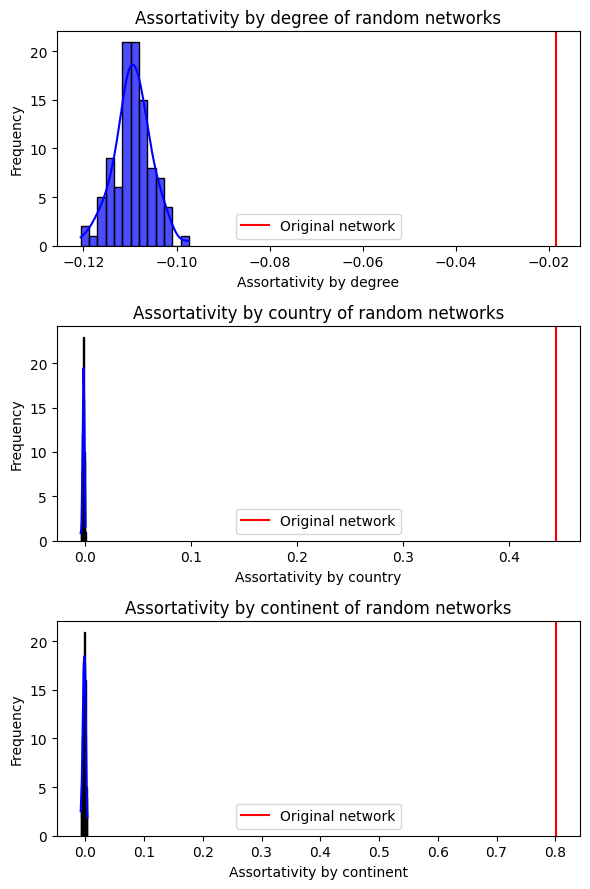

In [104]:
# Assuming assortativity calculations and list_of_graphs are defined as per your previous setup

# Calculate assortativity for random networks and the original network for degree, country, and continent
assortativity_by_degree_random = [calculate_assortativity_by_degree(graph) for graph in list_of_graphs]
assortativity_by_country_random = [assortativity_by_attribute(graph, 'country') for graph in list_of_graphs]
assortativity_by_continent_random = [assortativity_by_attribute(graph, 'continent') for graph in list_of_graphs]

# Setup a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9))
sns.histplot(assortativity_by_degree_random, kde=True, color='blue', alpha=0.7, ax=axs[0])
axs[0].axvline(assortativity_by_degree, color='red', label='Original network')
axs[0].set_xlabel('Assortativity by degree')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Assortativity by degree of random networks')
axs[0].legend()
sns.histplot(assortativity_by_country_random, kde=True, color='blue', alpha=0.7, ax=axs[1])
axs[1].axvline(assortativity_by_country, color='red', label='Original network')
axs[1].set_xlabel('Assortativity by country')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Assortativity by country of random networks')
axs[1].legend()
sns.histplot(assortativity_by_continent_random, kde=True, color='blue', alpha=0.7, ax=axs[2])
axs[2].axvline(assortativity_by_continent, color='red', label='Original network')
axs[2].set_xlabel('Assortativity by continent')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Assortativity by continent of random networks')
axs[2].legend()

plt.tight_layout()
plt.show()


### What can we say about this:
What we can see here is that our original graph contains a structure and therefore shows non-randomness with unique features for the graph. The explanation is that the graph is based on the geographic of the world, which by it self is not random. Furthermore, airports tends to be near cities or infrastructure, which probably ain’t random either.

### Including the BNP
We are interested in looking into the BNP per capita for the countries the airports are within and see if there is a connection between BNP per capita and countries/airports. And therefore helps answer reaches question 3.

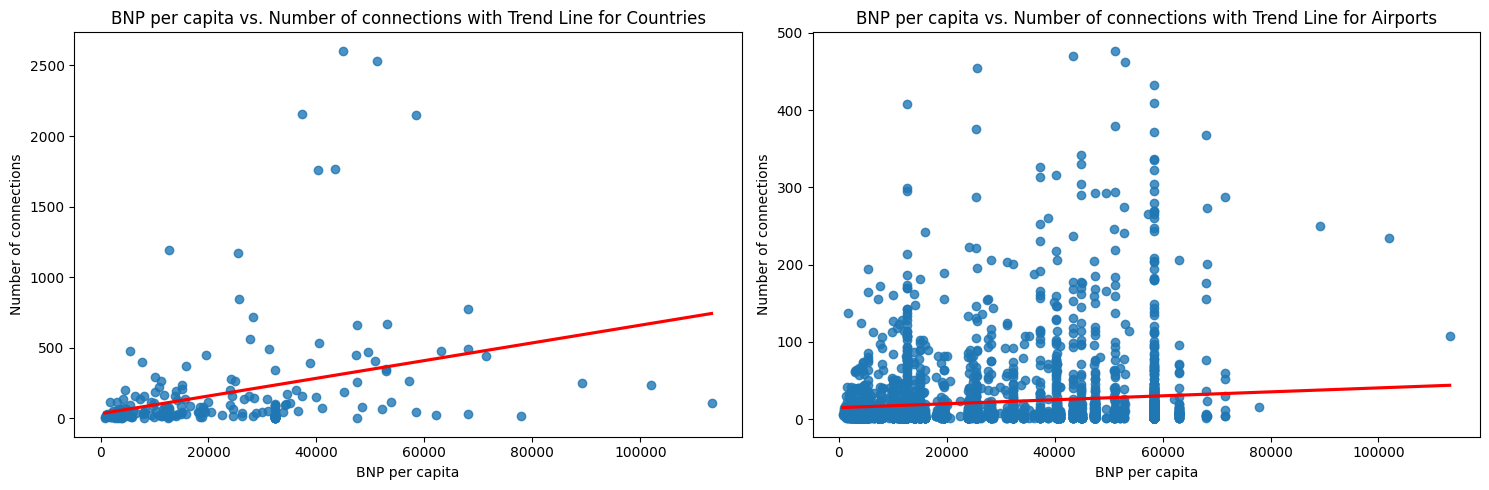

The correlation between BNP per capita and number of connections for countries is 0.3218
The correlation between BNP per capita and number of connections for airports is 0.1041


In [105]:
#Now we want to see if we can spot any patterens in BNP for countires and airports
#BNP for countries
bnp = {}
for k, v in IATA.items():
    if v['country'] not in bnp:
        bnp[v['country']] = v['BNP_per_capita']
bnp = {k: v for k, v in bnp.items() if v != 'unknown'}
connections = defaultdict(int)
for (u, v) in G.edges():
    country_u = IATA[u]['country']
    country_v = IATA[v]['country']
    if country_u != country_v:
        connections[country_u] += 1
        connections[country_v] += 1

connections = {k: v for k, v in connections.items() if k in bnp}
bnp_connections = {k: (bnp[k], v) for k, v in connections.items()}


bnp_values = [v[0] for k, v in bnp_connections.items()]
connections_values = [v[1] for k, v in bnp_connections.items()]
correlation = np.corrcoef(bnp_values, connections_values)
bnp_airports = {}
for k, v in IATA.items():
    if v['country'] in bnp:
        bnp_airports[k] = bnp[v['country']]
bnp_airports = {k: v for k, v in bnp_airports.items() if v != 'unknown'}

connections_airports = defaultdict(int)
for (u, v) in G.edges():
    if u in bnp_airports and v in bnp_airports:
        connections_airports[u] += 1
        connections_airports[v] += 1

bnp_connections_airports = {k: (bnp_airports[k], v) for k, v in connections_airports.items()}


#Find unique coutries and continents
countries = set([v['country'] for k, v in IATA.items()])
continent_to_country = {v['country']: v['continent'] for k, v in IATA.items()}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(
    x=[v[0] for k, v in bnp_connections.items()],
    y=[v[1] for k, v in bnp_connections.items()],
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
    ax=axs[0]
)
axs[0].set_xlabel('BNP per capita')
axs[0].set_ylabel('Number of connections')
axs[0].set_title('BNP per capita vs. Number of connections with Trend Line for Countries')

sns.regplot(
    x=[v[0] for k, v in bnp_connections_airports.items()],
    y=[v[1] for k, v in bnp_connections_airports.items()],
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
    ax=axs[1]
)
axs[1].set_xlabel('BNP per capita')
axs[1].set_ylabel('Number of connections')
axs[1].set_title('BNP per capita vs. Number of connections with Trend Line for Airports')
plt.tight_layout()

plt.show()

#Find the correlation between BNP per capita and number of connections for countries and airports
correlation_countries = np.corrcoef(bnp_values, connections_values)
correlation_airports = np.corrcoef([v[0] for k, v in bnp_connections_airports.items()], [v[1] for k, v in bnp_connections_airports.items()])
print(f"The correlation between BNP per capita and number of connections for countries is {correlation_countries[0, 1]:.4f}")
print(f"The correlation between BNP per capita and number of connections for airports is {correlation_airports[0, 1]:.4f}")

### What can we say about this:

As we can see on these graphs, we do have a positive correlation between countries/airports and the BNP per Capita. This means that wealthier countries tend to have airports with more connections. The relationship seems to be moderately strong given the dispersion of the data points around the trend line and the correlation. However, the correlation is not that strong if we look at each airport. This could affect the result of research question 3 since we now know there is a better chance to find those good airports within wealthier nations. If we look at centrality.

### Communities
We do now want to look at the communities next, due to os have a strong idea that the continent does somehow splits from eachother.

In [8]:
#FUnction that finds the communities
def find_communities(graph):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(graph.nodes()))
    G_ig.add_edges(list(graph.edges()))
    partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
    community_dict = {str(node): partition.membership[idx] for idx, node in enumerate(graph.nodes())}
    return community_dict

community_dict = find_communities(G)
num_communities = len(set(community_dict.values()))
community_sizes = np.bincount(list(community_dict.values()))
community_sizes = community_sizes[community_sizes > 0]
print(f"Community sizes: {community_sizes}")

#This is for inside of the communities
community_continents = {}
for i in range(num_communities):
    community_nodes = [n for n, comm in community_dict.items() if comm == i]
    continent_counts = {}
    for node in community_nodes:
        if node in IATA and 'continent' in IATA[node]:
            continent = IATA[node]['continent']
            if continent in continent_counts:
                continent_counts[continent] += 1
            else:
                continent_counts[continent] = 1
    if continent_counts:
        dominant_continent = max(continent_counts, key=continent_counts.get)
        community_continents[i] = {
            'dominant_continent': dominant_continent,
            'continent_details': continent_counts
        }

print(f"Community continents: {community_continents}")

Community sizes: [670 527 492 475 277 267 171 131 107  28  23  22  10  10   9   7   6   5
   4   4   4   3   2   2]
Community continents: {0: {'dominant_continent': 'North America', 'continent_details': {'North America': 641, 'Oceania': 1, 'South America': 27, 'Europe': 1}}, 1: {'dominant_continent': 'Asia', 'continent_details': {'Africa': 260, 'Europe': 2, 'Asia': 265}}, 2: {'dominant_continent': 'Asia', 'continent_details': {'Oceania': 5, 'Asia': 487}}, 3: {'dominant_continent': 'Europe', 'continent_details': {'Europe': 440, 'Africa': 25, 'Asia': 10}}, 4: {'dominant_continent': 'South America', 'continent_details': {'South America': 277}}, 5: {'dominant_continent': 'Oceania', 'continent_details': {'Oceania': 265, 'South America': 1, 'Asia': 1}}, 6: {'dominant_continent': 'Europe', 'continent_details': {'Europe': 125, 'Asia': 46}}, 7: {'dominant_continent': 'North America', 'continent_details': {'North America': 131}}, 8: {'dominant_continent': 'North America', 'continent_details': {'

### What can we say about this:
This shows that there exist multiple large communities, which represent major flight hubs. The small ones may represent smaller and more specialist airports, like airports in remote areas. The next thing was to gain a deeper insight into where the airports were placed. As we can see on the last output, the communities mainly are continental things, which does make sense since the assortativity by continent of the original network is 0.8016.

Documentation for leidenalg.find_partition can be found here (https://leidenalg.readthedocs.io/en/stable/reference.html).

Therefore it is interesting to look into each continent as a community and what we are doing here:

In [9]:
#Find all unique continents
continents = set([v['continent'] for k, v in IATA.items()])

#Remove Antarctica due to it not haveing valid airports
continents = [i for i in continents if i != 'Antarctica']

#Find the subgraphs for each continent
subgraphs = []
for i in continents:
    continent_airports = [k for k, v in IATA.items() if v['continent'] == i]
    continent_airports = [k for k in continent_airports if G.has_node(k)]
    subgraph = G.subgraph(continent_airports)
    subgraphs.append(subgraph)

for i, subgraph in enumerate(subgraphs):
    continent = list(continents)[i]
    print(f"Continent: {continent}, Number of airports: {subgraph.number_of_nodes()}")

#Now we want to find the basic properties of the subgraphs
subgraph_properties = []
for i, subgraph in tqdm(enumerate(subgraphs), desc='Calculating subgraph properties', total=len(subgraphs)):
    subgraph_properties.append({
        'Continent': list(continents)[i],
        'Number of nodes': subgraph.number_of_nodes(),
        'Number of edges': subgraph.number_of_edges(),
        'Density': nx.density(subgraph),
        'Average degree': np.mean([d for n, d in subgraph.degree()]),
        'Average clustering coefficient': nx.average_clustering(subgraph)
    })

subgraph_properties = pd.DataFrame(subgraph_properties)
subgraph_properties.head(6)

Continent: Asia, Number of airports: 812
Continent: Africa, Number of airports: 299
Continent: South America, Number of airports: 305
Continent: Oceania, Number of airports: 281
Continent: North America, Number of airports: 943
Continent: Europe, Number of airports: 616


Calculating subgraph properties: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Continent  Number of nodes  Number of edges   Density  Average degree  \
0           Asia              812             8375  0.012718       20.628079   
1         Africa              299             1369  0.015364        9.157191   
2  South America              305             1423  0.015347        9.331148   
3        Oceania              281             1086  0.013803        7.729537   
4  North America              943             8511  0.009581       18.050901   
5         Europe              616            10844  0.028624       35.207792   

   Average clustering coefficient  
0                        0.516831  
1                        0.461607  
2                        0.388292  
3                        0.503871  
4                        0.472613  
5                        0.434618

To talk about this we have to split it up into the continents. (Antarctica is removed due to not having any valid airports)

1. Africa: Africa shows moderate connectivity and a relatively high clustering, suggesting regional networks with several direct interconnections.

2. North America: North America has a high degree and with the high clustering it means that North America has high regional connectivity.

3. South America: Have low average degree and clustering, this means that the airports may be connected in "lines".

4. Oceania: Oceania has the highest clustering, this is probably due to the geographic constraints that the continent has. Furthermore, the area doesn't have a high average degree, which means that the airports are sparsely distributed.

5. Europe: As a major transport hub Europe has a very dense network with the highest degree and pretty high clustering. This means that airports in Europe are well-connected.

6. Asia: Asia has a large network with the highest clustering coefficient, indicating a highly integrated network where many airports are directly interconnected, forming many clusters.

Amount of top airports {'Asia': 21, 'Africa': 4, 'South America': 2, 'Oceania': 2, 'North America': 24, 'Europe': 47}


C:\Users\Rasmu\AppData\Local\Temp\ipykernel_8360\1445787570.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22924927151337895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subgraph_properties.at[i, 'Average composite score'] = np.mean(composite_scores)
C:\Users\Rasmu\AppData\Local\Temp\ipykernel_8360\1445787570.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17518.919056938852' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subgraph_properties.at[i, 'Average BNP per capita'] = np.mean(bnp_values)


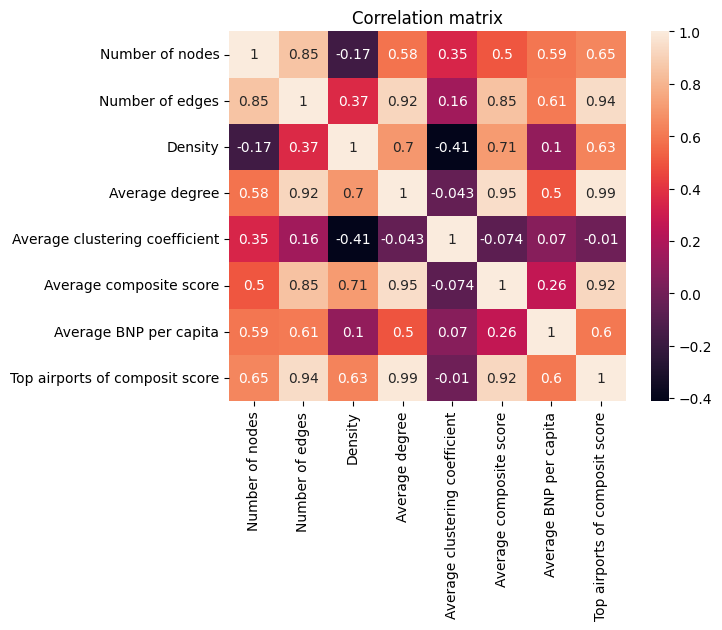

In [10]:
#Top 100 airports by composite score
top_airports = sorted_composite_score[:100]

list_of_continents = []
for i in range(0, 100):
    node = top_airports[i][0]
    continent = IATA[node]['continent']
    list_of_continents.append(continent)

#Find amount of all continents
continent_counts = {continent: list_of_continents.count(continent) for continent in continents}
continent_counts = {k: v for k, v in continent_counts.items() if v > 0}
print("Amount of top airports",continent_counts)

#Add this as a new column to the subgraph properties with average composite score and BNP per capita
subgraph_properties['Average composite score'] = 0
subgraph_properties['Average BNP per capita'] = 0
for i, subgraph in enumerate(subgraphs):
    airports = subgraph.nodes()
    composite_scores = [airport_composite_score[n] for n in airports]
    bnp_values = [IATA[n]['BNP_per_capita'] for n in airports if IATA[n]['BNP_per_capita'] != 'unknown']
    subgraph_properties.at[i, 'Average composite score'] = np.mean(composite_scores)
    subgraph_properties.at[i, 'Average BNP per capita'] = np.mean(bnp_values)

#Add the amount of top airports to the subgraph properties
subgraph_properties['Top airports of composit score'] = [continent_counts[continent] for continent in subgraph_properties['Continent']]
#See if there is any correlation between amount of top airports and all the other properties without continent and create a heatmap
df = subgraph_properties.drop(columns=['Continent'])
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


### What can we say about this:

From this analysis of continents, we can say that larger and more connected airport networks tend to include more top-rated airports and also achieve higher average composite scores, which likely reflect greater overall network effectiveness and centrality. However, the specific setup of the network as density local clustering and economic status of the region also play roles in the result.

Some short notes on specific results:

1. Results like several nodes and several edges are pretty logical and therefore expected.
2. Since the top airports are ranked by composite score, it does make sense.
3. On the other hand, regions with more airports and more connections also tend to have more top airports, which may reflect larger and more complex airport networks.
4. However, a lower density indicates fewer connections relative to the number of nodes, which in turn might suggest that having a tightly connected network is not necessary for having a higher number of top airports.
5. We can see that economically richer regions tend to have more connections, which fit into the previous discoveries.
6. At last it does show a tendency between the average BNP per capita and amount of top airports.


To discuss the research questions, we can see that BNP per capita is correlated with the top airports. Furthermore, continents with a higher amount of edges do have more of the top airports.

### Combining reviews and airports

The reviews also are important in this project, and specific for the second reaches question. Therefore we will investigate the assortivity for average rating, BNP, and average recommendation per capita. So far we have talked about the composite value as a way of measuring how good an airport is, however, it is sometimes more giving to look at what people mean as a way of saying how good an airport is.

In [113]:
#FInd the numeric assortativity coefficient
BNP_per_capita_review = nx.numeric_assortativity_coefficient(G_review, 'BNP_per_capita')
average_recommendation_review = nx.numeric_assortativity_coefficient(G_review, 'average_recommendation')
average_recommendation_per_BNP_review = nx.numeric_assortativity_coefficient(G_review, 'average_recommendation_per_BNP')

print("Numeric assortativity coefficient for BNP_per_capita:", BNP_per_capita_review)
print("Numeric assortativity coefficient for average_recommendation:", average_recommendation_review)
print("Numeric assortativity coefficient for average_recommendation_per_BNP:", average_recommendation_per_BNP_review)

Numeric assortativity coefficient for BNP_per_capita: -0.08574480301177222
Numeric assortativity coefficient for average_recommendation: -0.007834990772506403
Numeric assortativity coefficient for average_recommendation_per_BNP: -0.033791608502183365


### What can we say about this:
We can say that there is no tendency for airports to connect to other airports with the same level of good reviews. Therefore we can answer our second research question and say no, there is no such tendency in good airports mostly connect to other well-rated airports.

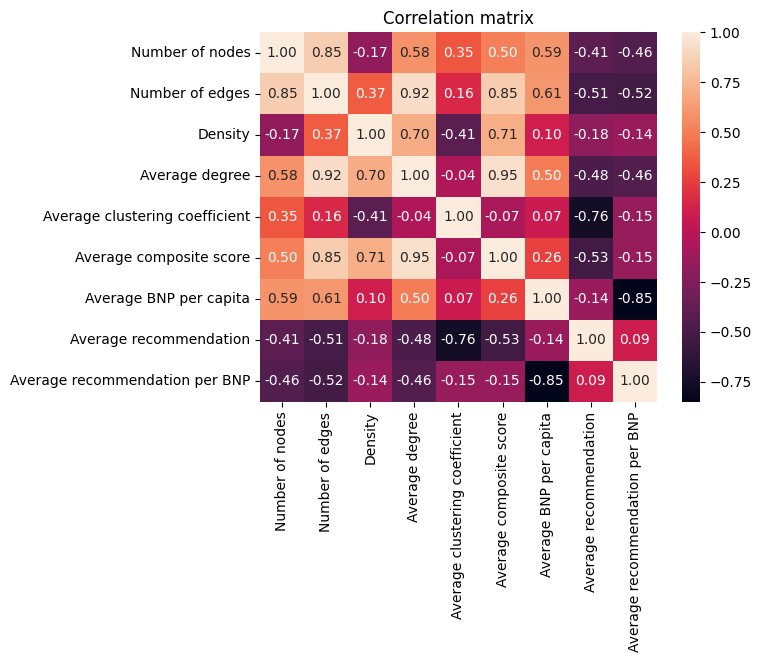

In [114]:
#See which continents and nation have the greatest average recommendation and average recommendation per BNP
average_recommendations = {}
average_recommendation_per_BNP_review = {}
for node in G_review.nodes():
    if 'average_recommendation' in G_review.nodes[node]:
        average_recommendations[node] = G_review.nodes[node]['average_recommendation']
    if 'average_recommendation_per_BNP' in G_review.nodes[node]:
        average_recommendation_per_BNP_review[node] = G_review.nodes[node]['average_recommendation_per_BNP']

average_recommendations_per_continent = defaultdict(list)
average_recommendation_per_BNP_per_continent = defaultdict(list)
for node, recommendation in average_recommendations.items():
    if node in IATA:
        continent = IATA[node]['continent']
        average_recommendations_per_continent[continent].append(recommendation)

for node, recommendation in average_recommendation_per_BNP_review.items():
    if node in IATA:
        continent = IATA[node]['continent']
        average_recommendation_per_BNP_per_continent[continent].append(recommendation)


average_recommendations_per_continent = {k: np.mean(v) for k, v in average_recommendations_per_continent.items()}
average_recommendation_per_BNP_per_continent = {k: np.mean(v) for k, v in average_recommendation_per_BNP_per_continent.items()}

#convert to pandas dataframe
average_recommendations_per_continent = pd.DataFrame(average_recommendations_per_continent.items(), columns=['Continent', 'Average recommendation'])
average_recommendation_per_BNP_per_continent = pd.DataFrame(average_recommendation_per_BNP_per_continent.items(), columns=['Continent', 'Average recommendation per BNP'])


#Make the order of the continents follow the order in subgraph_properties
average_recommendations_per_continent = average_recommendations_per_continent.set_index('Continent').reindex(subgraph_properties['Continent']).reset_index()
average_recommendation_per_BNP_per_continent = average_recommendation_per_BNP_per_continent.set_index('Continent').reindex(subgraph_properties['Continent']).reset_index()

#remove the continents from the two dataframes and add the average recommendation and average recommendation per BNP to the subgraph_properties
subgraph_properties['Average recommendation'] = average_recommendations_per_continent['Average recommendation']
subgraph_properties['Average recommendation per BNP'] = average_recommendation_per_BNP_per_continent['Average recommendation per BNP']

#Create a heatmap for the correlation matrix
df = subgraph_properties.drop(columns=['Continent','Top airports of composit score'])
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation matrix')
plt.show()

### What can we say about this:
In this case we are primarily looking at the Average recommendation and average recommendation per BNP. For both of them there seem to be a negative correlation between most of the measurments and highly connected airports does not means it have good recommendations.

# Dicussion
**What could have been improved?**<br>
We definitely could have needed more data on airport reviews. Even though we had a total of 17721 reviews, many of them had to be discarded since we couldn't confidently map them over to the corresponding airport name in our other dataset, and since most of the reviews where from Europe. So, even though our dataset consisted of 6033 airports, only 197 of them had reviews. A more in depth dataset over airport reviews could be obtained using the [Google Places Api](https://developers.google.com/maps/documentation/places/web-service/overview). 

What could be nice to have is how much an airport effect the nation's BNP per capita, since this would allow us to separate the airport economically.

**Ethical Discussion**
We have been working with airport data, so we haven’t touched upon personal information. But still, we want to talk about what the issue could be of using the data in an analysis of it. To include topics from the lectures, firstly, about the framework, we think that our research does lead us to a better way for some to make the airways more efficient. This falls into the consequentialism framework, but we do want to always consider the ethics of the sciences as the deontology describes, therefore, it is a mix. Secondly, the Foure Pircipals: As mentioned before we do not handle data about any persons, therefore, we will move further to Beneficiaries. The Beneficiary of this study is an overall study, that tries to focus on where the best airports might be and how economic factors affect it. However, there is a use of our analytics that could result in some gaining an economic advantage (we assume that the tendencies match what going on now). Justice is the third one and what we can conclude is that we are doing this as a non-profit project with very anonymous data. The share of risk is pretty low, but we cannot guarantee that some might use this with evil intentions, it could be terror. At last the respect for law and the public interest. We do find our project to be open, as everyone can see what we are doing with the data, as it will be an open GitHub in the future, and that we are using data that does not contain personal information. In the end, we do follow the common rules set by the government.


# Conclusion
There are several different ways of determining what a good airport is. We (mainly) looked at the following measures:
* Fraction of positive reviews
* Sentiment scores of textual reviews
* Connectivity of airports

We found that the most highly appraised airports in terms of sentiment scores is found in Asia with a mean sentiment score of ~0.55. However, in terms of actual fraction of positive reviews, the Asian airports scores bottom last, and South American airports, though with a big uncertainty, scores the highest with a fraction of positive reviews of ~0.5. In terms of where exactly the good airports are placed in the world, we can say that  northern and southern South America, aswell as eastern North America and eastern Asia specifically has the highest scoring airports in terms of fraction of positive reviews. South eastern Africa is very confidently the best area for airports that outperforms expectations when adjusted for BNP.

When it comes to the connectivity of the network we found that the most connected areas were Europe, Asia, and North America. Therefore, most central airports were inside these continents. The airports with the highest composite score do not show the tendency to connect primarily with other well-connected airports, therefore not an assortative network. However, we found some correlation between the BNP per capita and the composite score, 0.26 for the composite score and 0.53 for the top airports of the composite score. 